In [57]:
import glob
import pandas as pd
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

# Leading SPACE!!!
angle_type_prefix = ' pose_R'
angle_type_prefix = ' p_r'

FILTER_KERNEL = 9 # 7 or 9 si max
FRAME_RATE = 30

def get_peaks_params(head_class, angle_type):
    
    reach_ends_cnt = 0
    all_widths = []
    all_heights = []
    avg_w = []
    avg_h = []

    # CHANGE PATH!!!
    for csv_file in glob.glob('./data/' + head_class + '/*.csv'):
        df = pd.read_csv(csv_file)

        # Resample to common frame rate
        csv_frame_rate = (df.shape[0] - 1) / np.sum(np.diff(df[' timestamp']))
        # print('csv frame rate: ', csv_frame_rate)
        n_resampled_points = int(1 + (len(df[angle_type]) - 1) * FRAME_RATE / csv_frame_rate)
        angles = scipy.signal.resample(df[angle_type], num=n_resampled_points)
        
        # Take first derivative of the signal
        angles = np.diff(angles)

        # Apply median filter
#         angles_filt = angles
        angles_filt = scipy.signal.medfilt(angles, kernel_size=FILTER_KERNEL)

#         fc = 3
#         b, a = scipy.signal.butter(N=2, Wn=2*fc/FRAME_RATE, btype='low', analog=False, output='ba')
    #     angles_filt = scipy.signal.filtfilt(b, a, angles)

        # Get peak locations
        pos_peaks, _ = scipy.signal.find_peaks(angles_filt)
        neg_peaks, _ = scipy.signal.find_peaks(-angles_filt)

        # Width and height for the current file/recording
        curr_w = []
        curr_h = []
        # Detect neighboring +- and -+
        i, j = 0, 0
        while i < len(pos_peaks) and j < len(neg_peaks):
            
            # Simple basic approach
#             w = abs(pos_peaks[i] - neg_peaks[j])
#             h = angles_filt[pos_peaks[i]] - angles_filt[neg_peaks[j]]
            
            # Height difference of adjacent extremes + - or - +
            h = angles_filt[pos_peaks[i]] - angles_filt[neg_peaks[j]]

            if pos_peaks[i] == neg_peaks[j]:
                raise Exception('Positive and negative peaks coincide!')
            # + -
            elif pos_peaks[i] < neg_peaks[j]:
                # Search left for first negative peak neg_peaks[j-1]
                if j <= 0:
                    left_end = 0
                    reach_ends_cnt += 1
                    print('L End reached + -')
                else:
                    left_end = neg_peaks[j-1]
                                    
                # Search right for first positive peak
                if i >= len(pos_peaks) - 1:
                    right_end = len(angles_filt) - 1
                    reach_ends_cnt += 1
                    print('R End reached + -')
                else:
                    right_end = pos_peaks[i+1]
                                        
                i += 1
                
            # - +
            else:
                # Search left for first positive peak
                if i <= 0:
                    left_end = 0
                    reach_ends_cnt += 1
                    print('L End reached - +')
                else:
                    left_end = pos_peaks[i-1]
                                    
                # Search right for first negative peak
                if j >= len(neg_peaks) - 1:
                    right_end = len(angles_filt) - 1
                    reach_ends_cnt += 1
                    print('R End reached - +')
                else:
                    right_end = neg_peaks[j+1]
                                
                j += 1
                
            w = abs(right_end - left_end)
                
# Based on zero crossings
#             # + -
#             elif pos_peaks[i] < neg_peaks[j]:
#                 # Search left for first negative
#                 ii = pos_peaks[i] - 1
#                 while ii >= 0 and angles_filt[ii] > 0:
#                     ii -= 1
#                 # Zero found or ii out of bounds
#                 if ii < 0:
#                     ii = 0
#                     print('L End reached + -')
                
#                 # Search right for first positive
#                 jj = neg_peaks[j] + 1
#                 while jj < len(angles_filt) and angles_filt[jj] < 0:
#                     jj += 1
#                 # Zero found or jj out of bounds
#                 if jj >= len(angles_filt):
#                     jj = len(angles_filt) - 1
#                     print('R End reached + -')
                    
#                 i += 1
                
#             # - +
#             else:
#                 # Search left for first positive
#                 jj = neg_peaks[j] - 1
#                 while jj >= 0 and angles_filt[jj] < 0:
#                     jj -= 1
#                 # Zero found or jj out of bounds
#                 if jj < 0:
#                     jj = 0
#                     print('L End reached - +')
                    
#                 # Search right for first negative
#                 ii = pos_peaks[i] + 1
#                 while ii < len(angles_filt) and angles_filt[ii] > 0:
#                     ii += 1
#                 # Zero found or ii out of bounds
#                 if ii >= len(angles_filt):
#                     ii = len(angles_filt) - 1
#                     print('R End reached - +')
                                
#                 j += 1
                
#             w = abs(ii - jj)
            
            curr_w.append(w)
            curr_h.append(h)            
            all_widths.append(w)
            all_heights.append(h)
            
        print(f'Widths: {curr_w}')
                
        # If no peaks found and it is other class, add zero peak
        if len(curr_w) == 0:
            if head_class == 'other':
                avg_w.append(0)
                avg_h.append(0)
                all_widths.append(0)
                all_heights.append(0)
        else:
            avg_w.append(np.mean(curr_w))
            avg_h.append(np.mean(curr_h))

        # Plot
        plt.figure(figsize=(14, 4))
        
        plt.plot(angles, 'k-o', label='original')
        plt.plot(angles_filt, 'orange', label='filtered')
        
        for p in pos_peaks:
            plt.axvline(p, color='red')
        for p in neg_peaks:
            plt.axvline(p, color='blue')
    #     plt.tight_layout(h_pad=-4.9)
        plt.legend()
        plt.xlim(0, 200)
        plt.show()
    #     break

    print(f'Ends reached {reach_ends_cnt} times')
    return all_widths, all_heights, avg_w, avg_h


L End reached - +
R End reached + -
Widths: [17, 18, 16, 12]


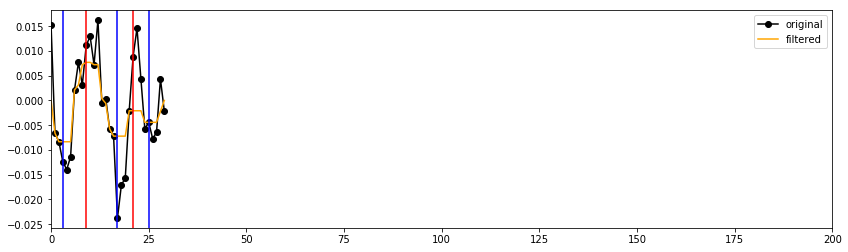

L End reached + -
R End reached + -
Widths: [22]


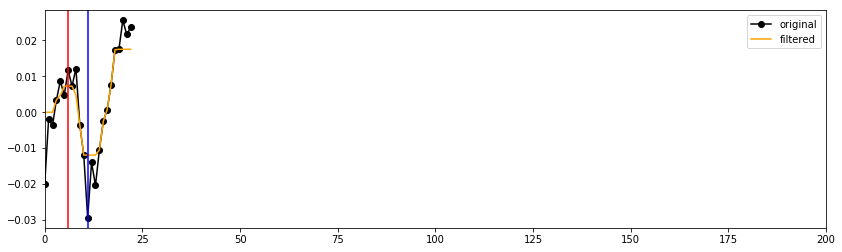

L End reached + -
R End reached - +
Widths: [21, 15, 10, 3, 3, 5]


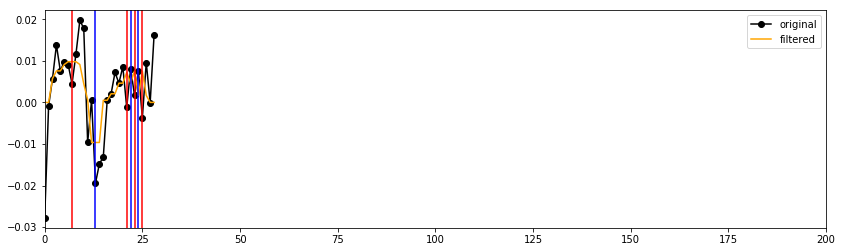

L End reached + -
R End reached + -
Widths: [20, 26, 23]


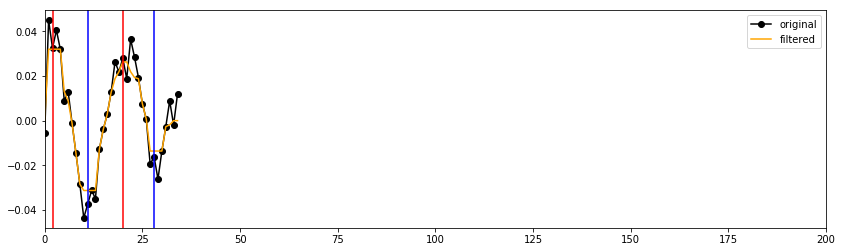

L End reached - +
R End reached + -
Widths: [17, 18, 15, 17, 13, 12]


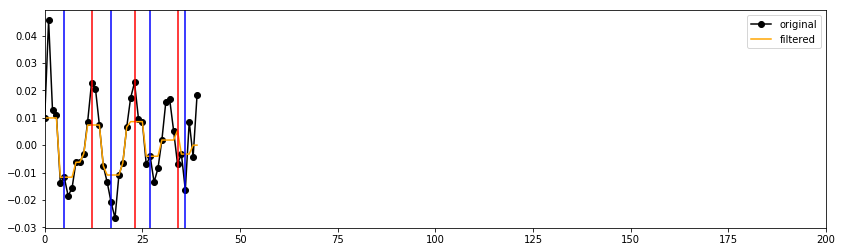

L End reached - +
R End reached + -
Widths: [21, 23, 23, 19, 22, 18]


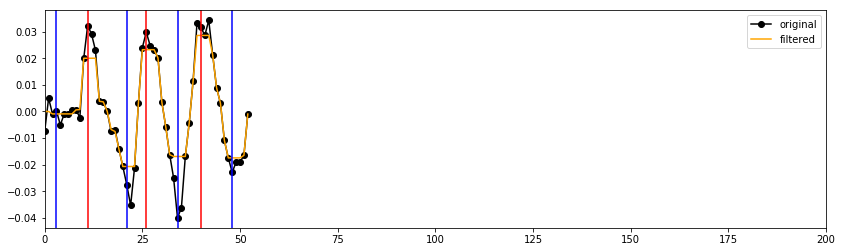

L End reached - +
R End reached - +
Widths: [17, 18, 18, 18, 18]


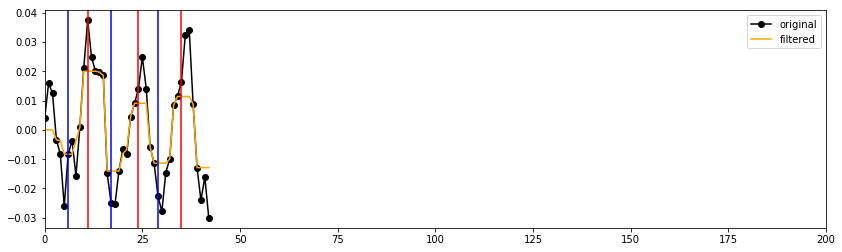

L End reached - +
R End reached - +
Widths: [5, 3, 3, 10, 10, 11, 7]


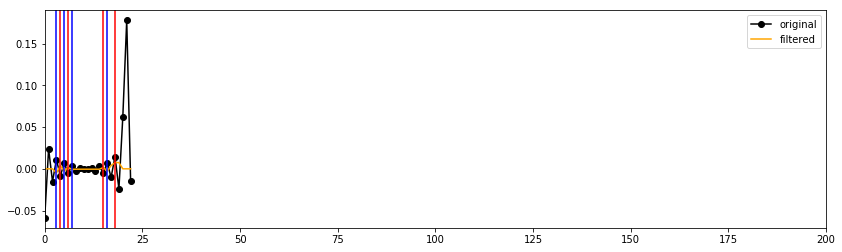

L End reached + -
R End reached - +
Widths: [23, 33, 29, 23]


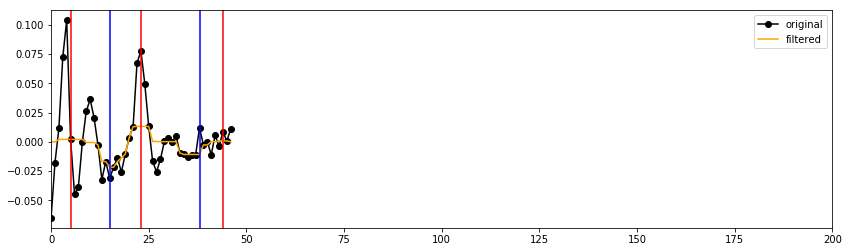

L End reached - +
R End reached + -
Widths: [14, 18, 18, 19, 19, 19, 20, 18, 19, 14]


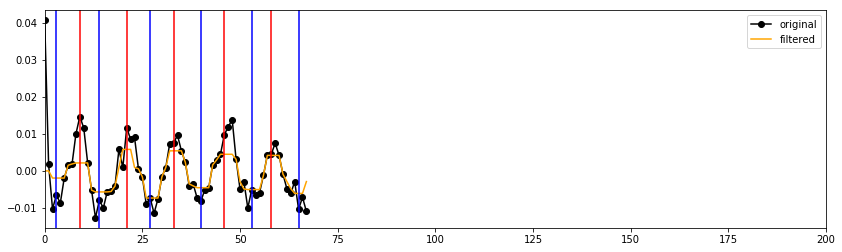

L End reached - +
R End reached + -
Widths: [16, 18, 13, 15]


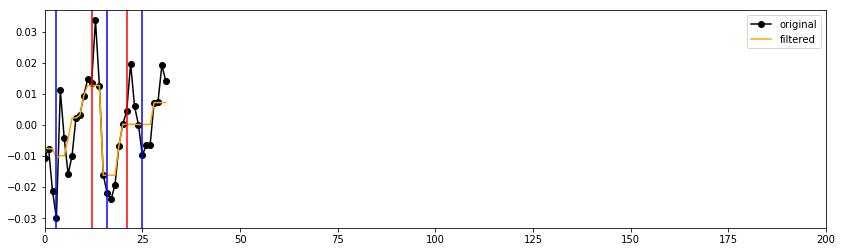

L End reached + -
R End reached + -
Widths: [16, 14, 11, 11, 13]


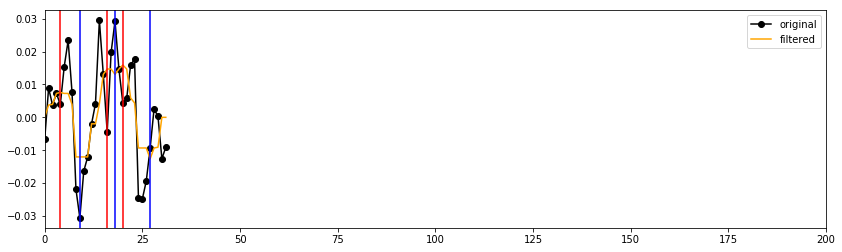

L End reached - +
R End reached - +
Widths: [21, 23, 22, 19, 18]


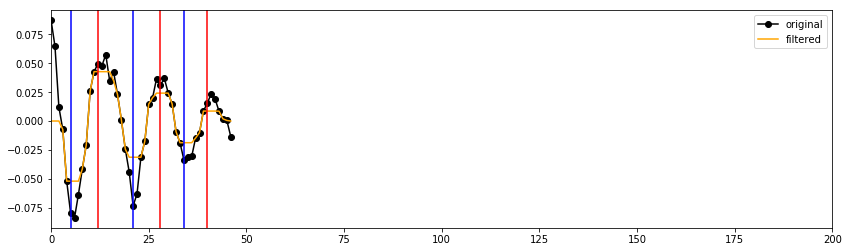

L End reached + -
R End reached - +
Widths: [12, 15, 15, 14, 14, 21]


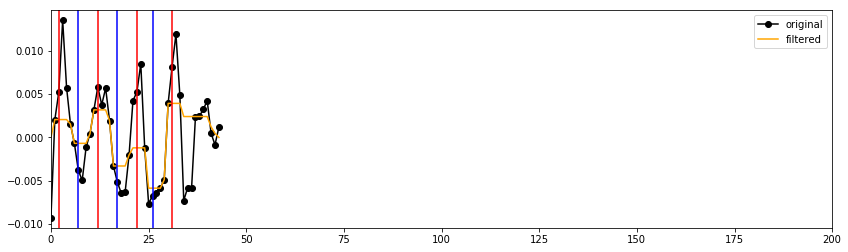

L End reached - +
R End reached + -
Widths: [16, 21]


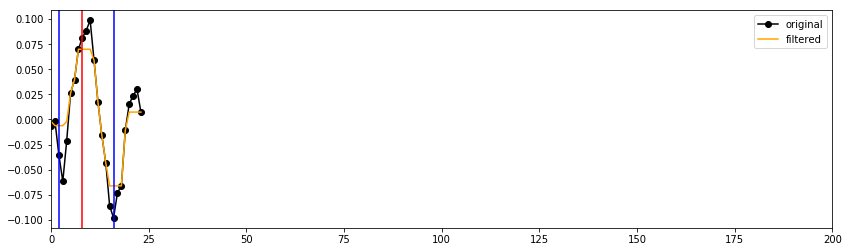

L End reached + -
R End reached + -
Widths: [13]


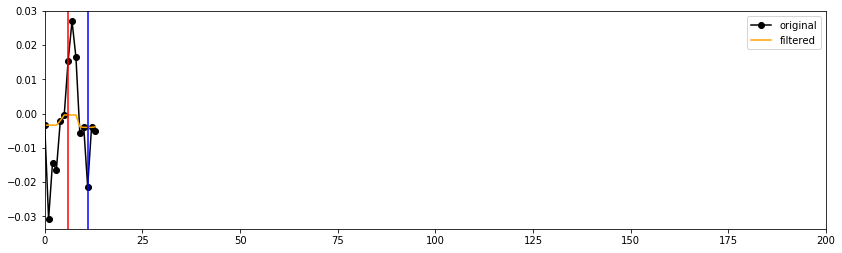

L End reached - +
R End reached + -
Widths: [30, 34, 26, 23]


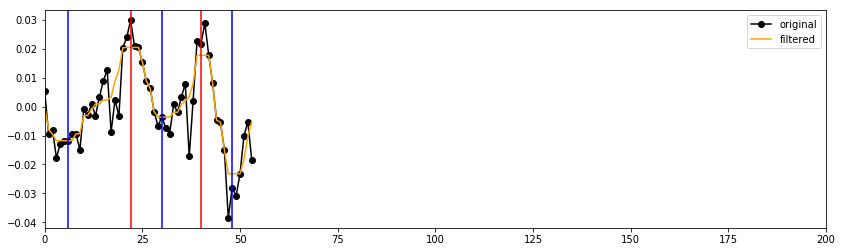

L End reached + -
R End reached + -
Widths: [15, 25, 26, 29, 19]


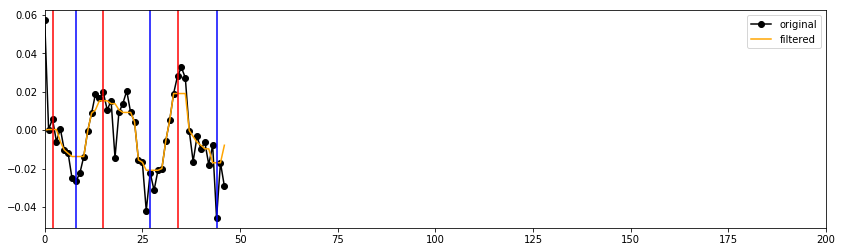

L End reached + -
R End reached + -
Widths: [13, 17, 15]


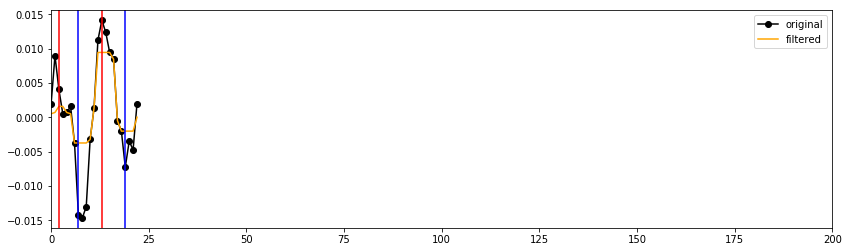

L End reached + -
R End reached + -
Widths: [20]


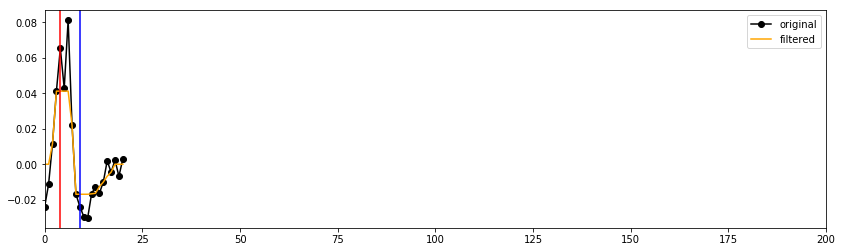

L End reached - +
R End reached - +
Widths: [15, 20, 20]


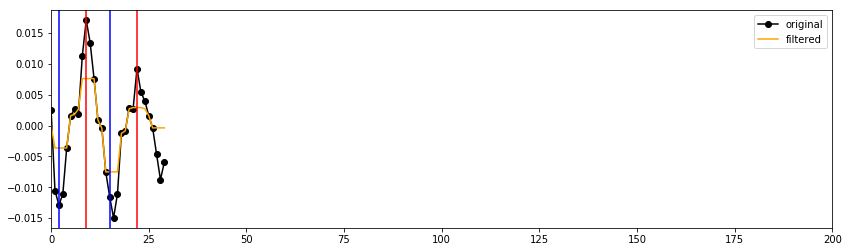

L End reached + -
R End reached + -
Widths: [10, 10, 7, 23, 29]


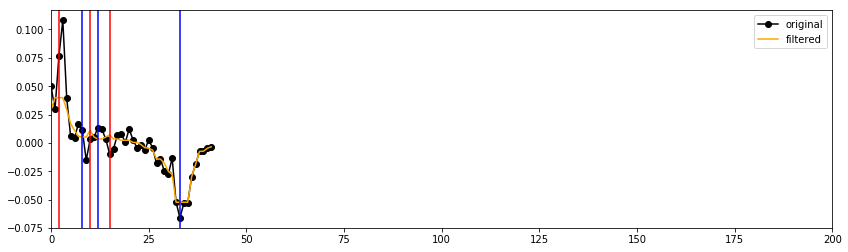

L End reached + -
R End reached + -
Widths: [24, 28, 21, 17, 21, 33, 35, 36, 32, 36, 30, 29, 16, 12, 13, 24, 27]


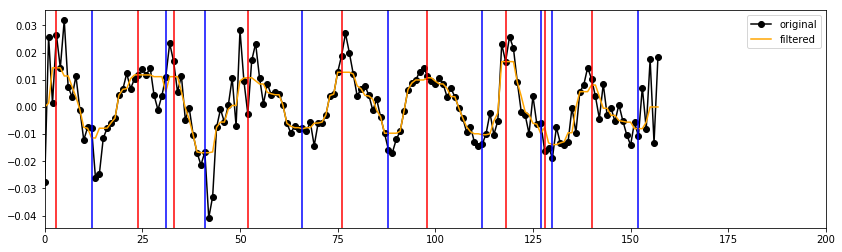

L End reached + -
R End reached - +
Widths: [21, 21, 19, 20]


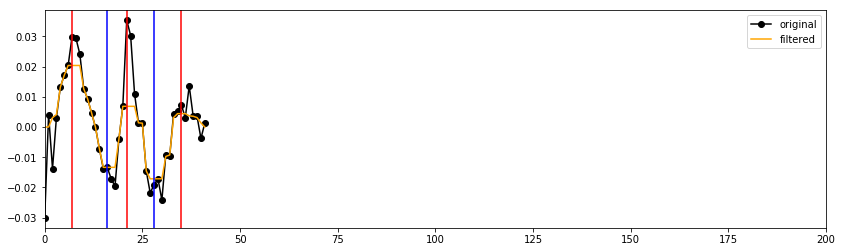

L End reached - +
R End reached - +
Widths: [19]


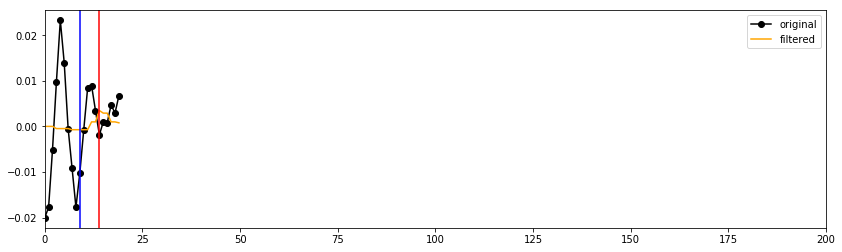

L End reached + -
R End reached - +
Widths: [17, 20]


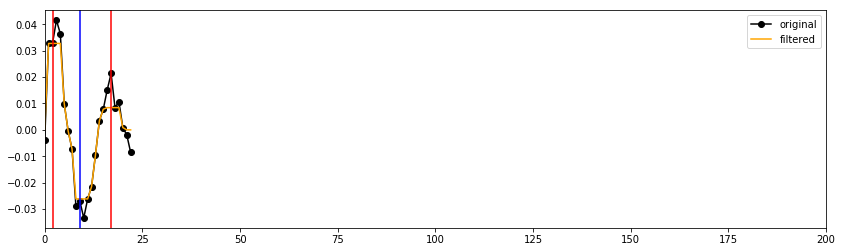

L End reached + -
R End reached + -
Widths: [20, 24, 21]


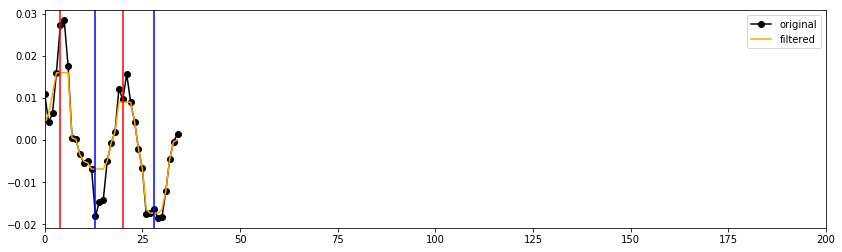

L End reached - +
R End reached - +
Widths: [22, 23, 15, 9, 4, 5, 6, 9, 10]


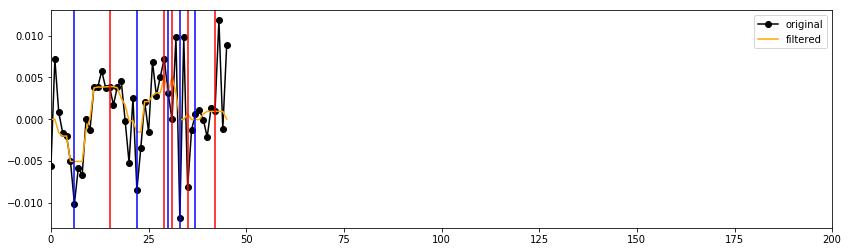

L End reached + -
R End reached - +
Widths: [15, 15]


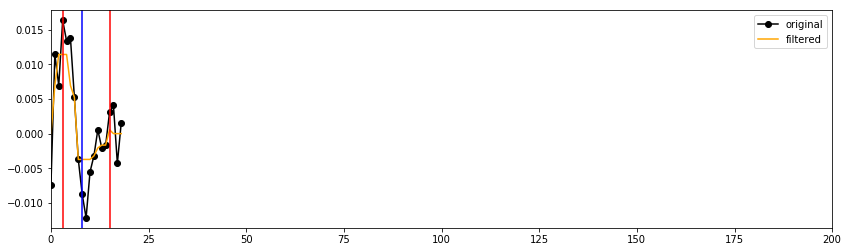

L End reached + -
R End reached + -
Widths: [18, 20, 15]


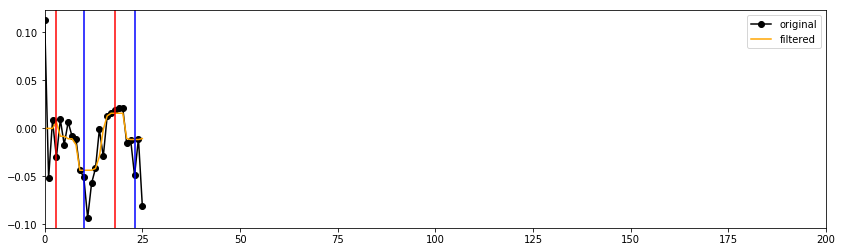

L End reached - +
R End reached + -
Widths: [8, 6, 4, 10, 16, 24, 26, 29, 26, 22]


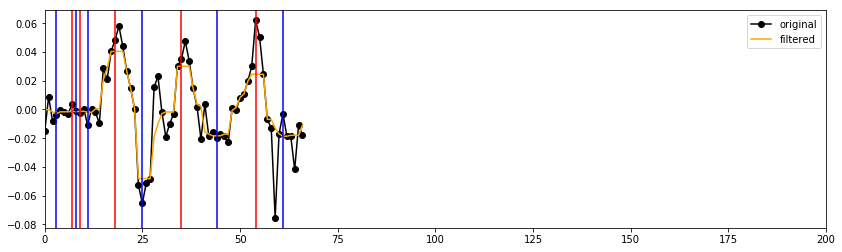

L End reached + -
R End reached + -
Widths: [14]


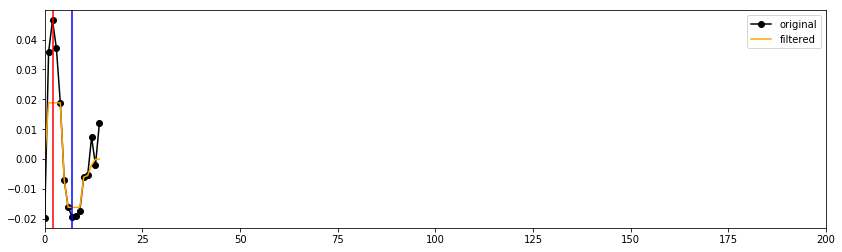

L End reached - +
R End reached - +
Widths: [17]


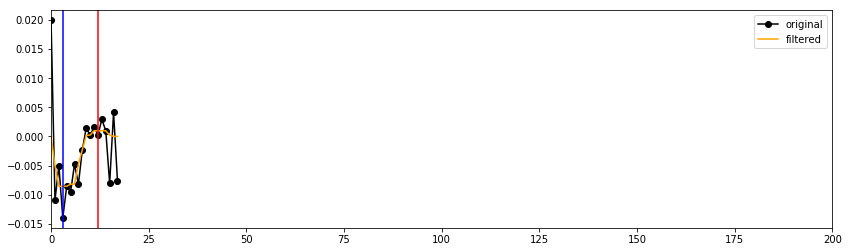

L End reached - +
R End reached + -
Widths: [21, 22, 18, 16, 17, 20, 20, 19, 15, 16, 16, 20]


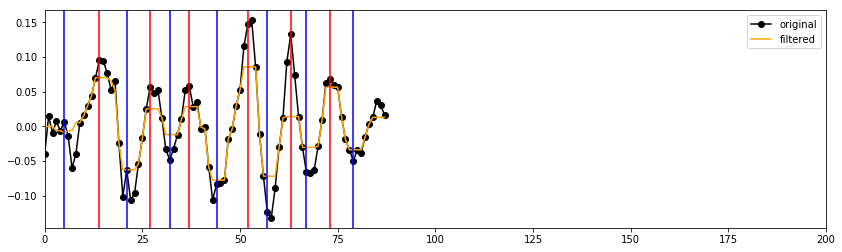

L End reached - +
R End reached - +
Widths: [16, 20, 26]


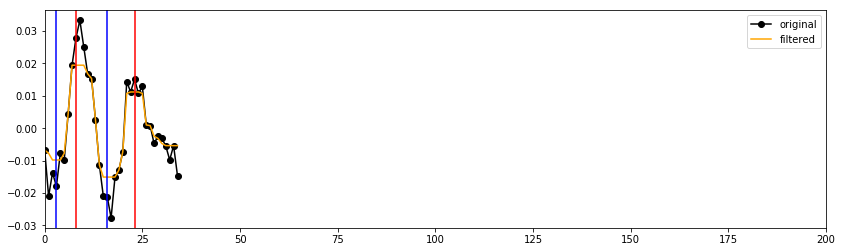

L End reached - +
R End reached + -
Widths: [17, 18, 19, 23, 29, 32, 38, 36, 33, 22]


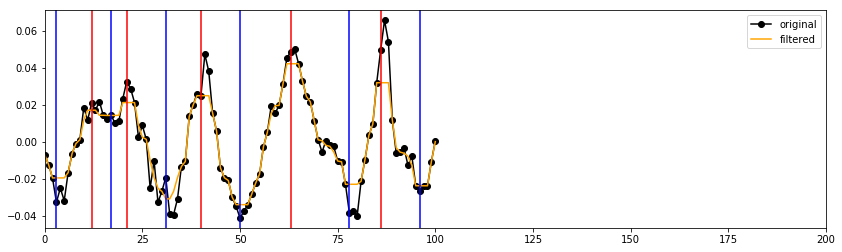

L End reached - +
R End reached - +
Widths: [20, 26, 28, 29, 25]


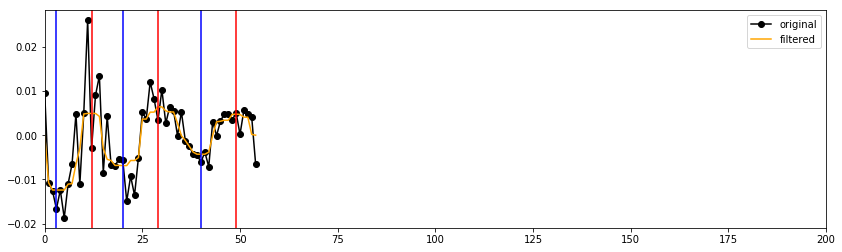

L End reached - +
R End reached + -
Widths: [14, 18, 18, 20]


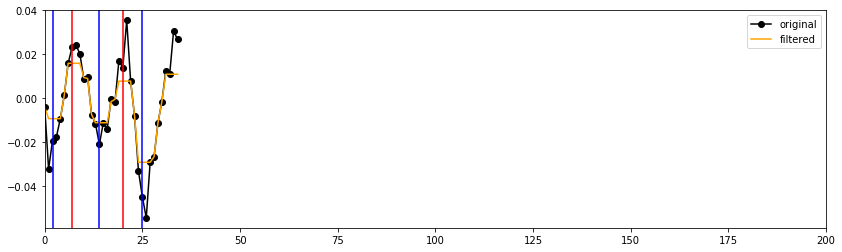

Widths: []


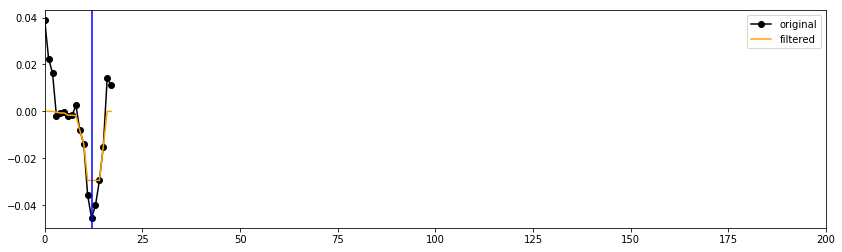

L End reached + -
R End reached - +
Widths: [18, 18]


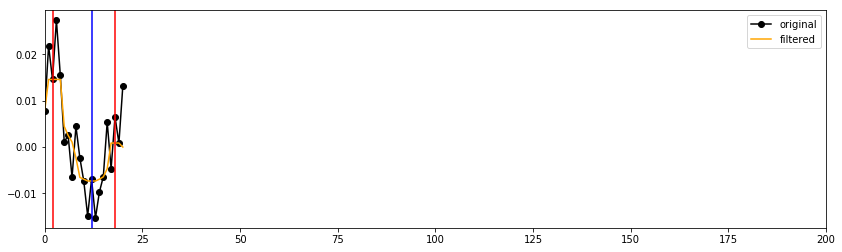

L End reached + -
R End reached + -
Widths: [18, 21, 16, 12, 8]


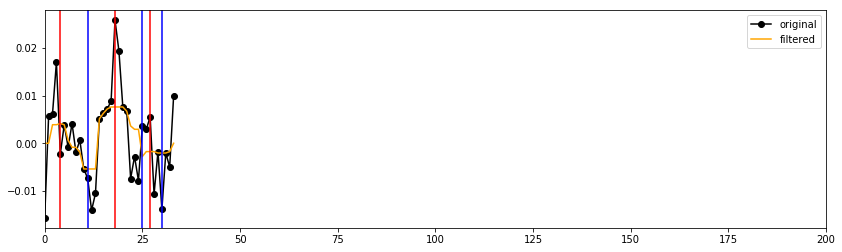

L End reached - +
R End reached - +
Widths: [19]


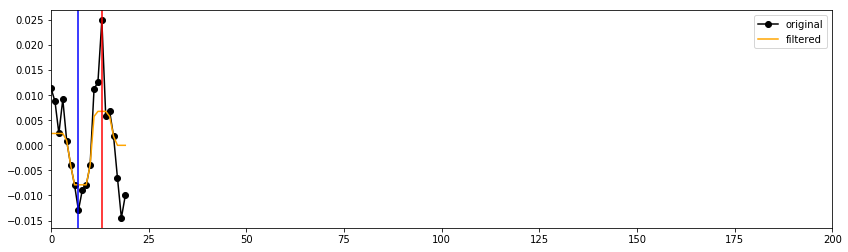

L End reached + -
R End reached + -
Widths: [20, 23, 16, 16, 15]


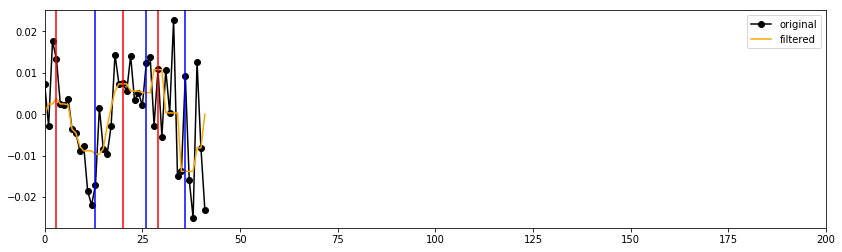

L End reached + -
R End reached - +
Widths: [10, 12, 12, 17]


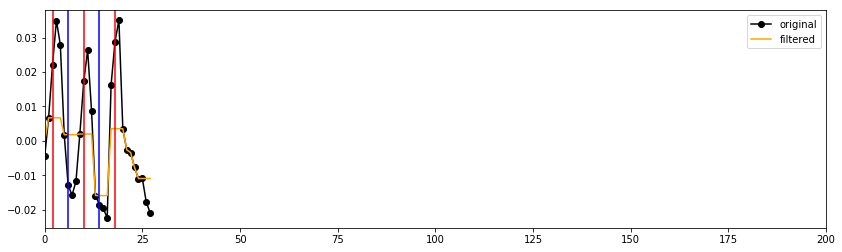

L End reached + -
R End reached + -
Widths: [22]


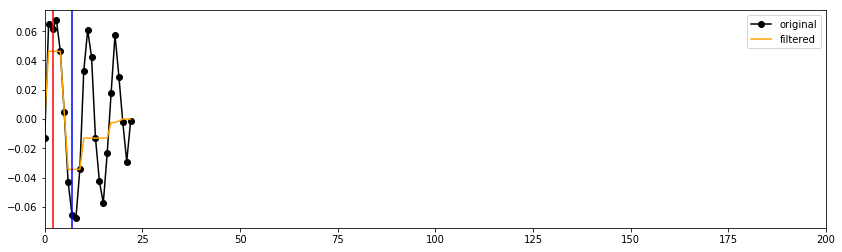

L End reached - +
R End reached - +
Widths: [11, 15, 16, 17, 16, 18, 16, 16, 13]


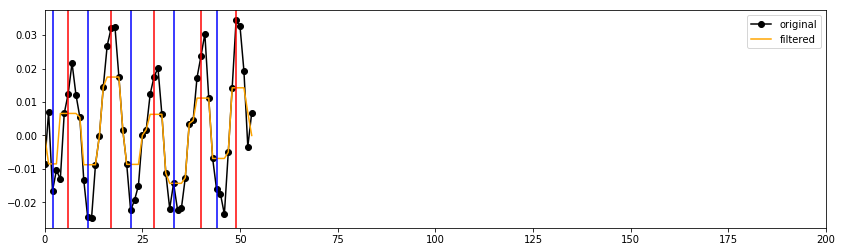

L End reached + -
R End reached + -
Widths: [23, 22, 17]


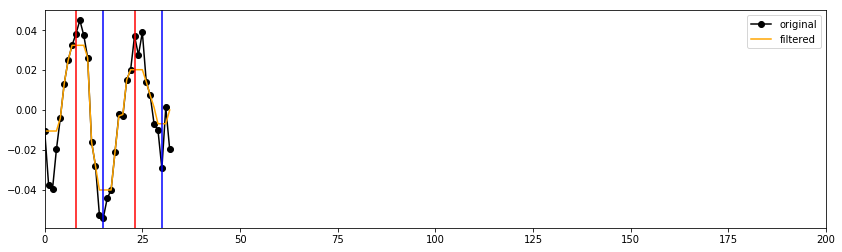

L End reached + -
R End reached + -
Widths: [19, 20, 20, 24, 24, 26, 23, 20, 14]


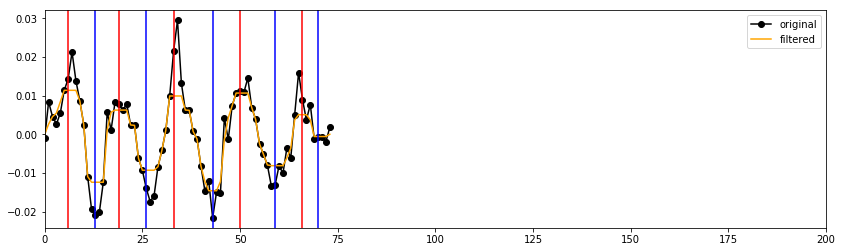

L End reached + -
R End reached - +
Widths: [19, 17, 16, 12]


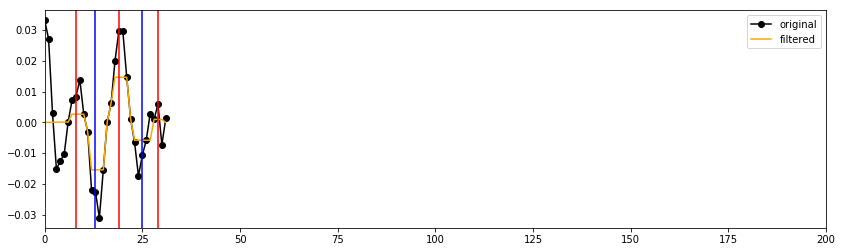

L End reached - +
R End reached + -
Widths: [13, 17, 17, 16, 14, 14]


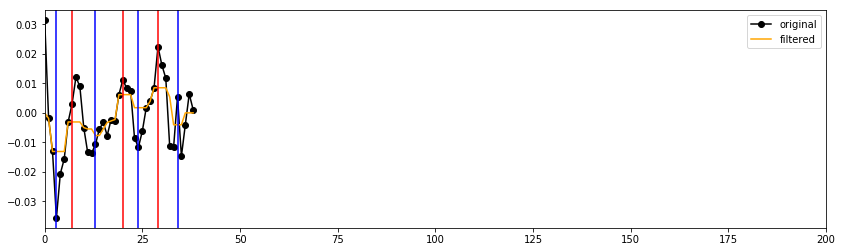

L End reached + -
R End reached + -
Widths: [16]


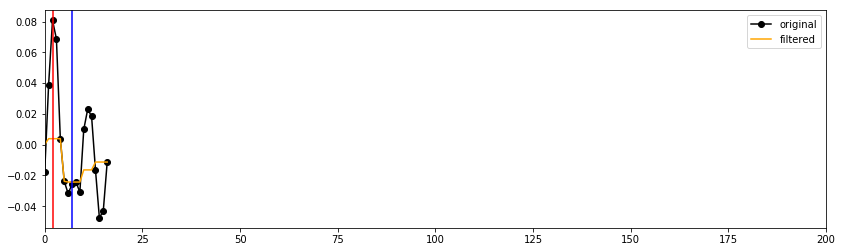

L End reached + -
R End reached + -
Widths: [16, 21, 20, 18, 13]


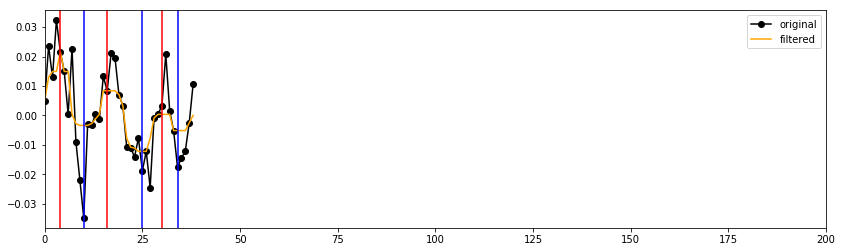

L End reached + -
R End reached + -
Widths: [13, 11, 13, 24, 32, 39, 29]


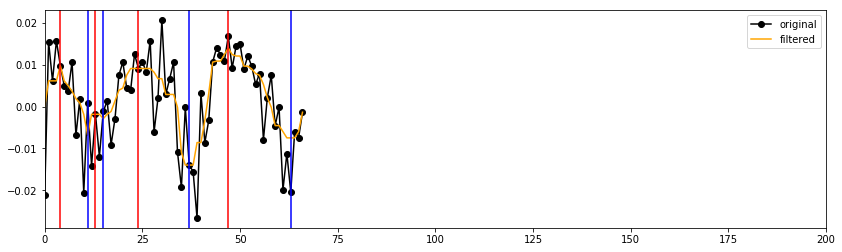

L End reached - +
R End reached - +
Widths: [24, 26, 14]


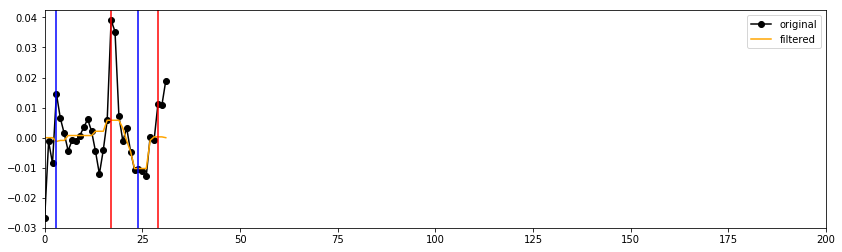

L End reached - +
R End reached + -
Widths: [34, 26]


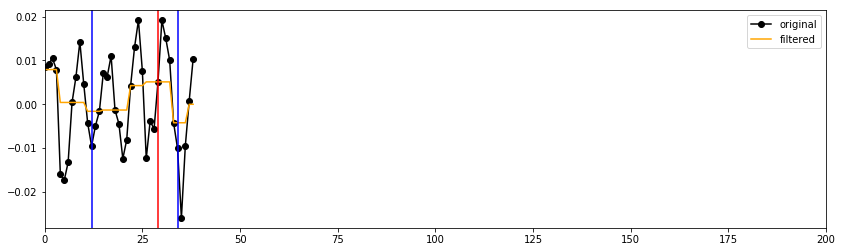

L End reached + -
R End reached - +
Widths: [17, 16]


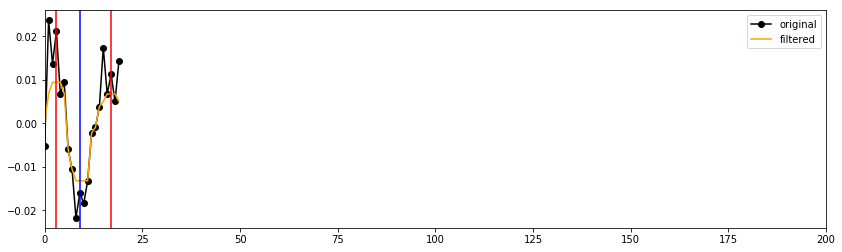

L End reached - +
R End reached + -
Widths: [15, 17]


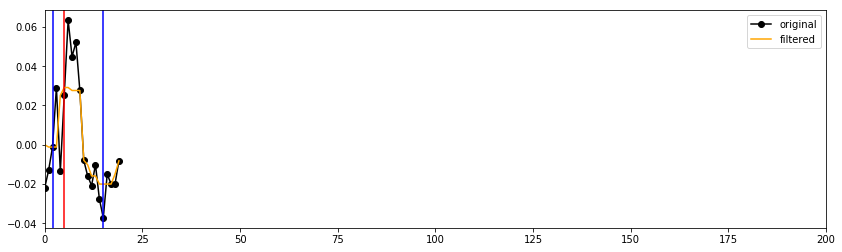

L End reached + -
R End reached + -
Widths: [24, 30, 30, 20, 13, 9, 5]


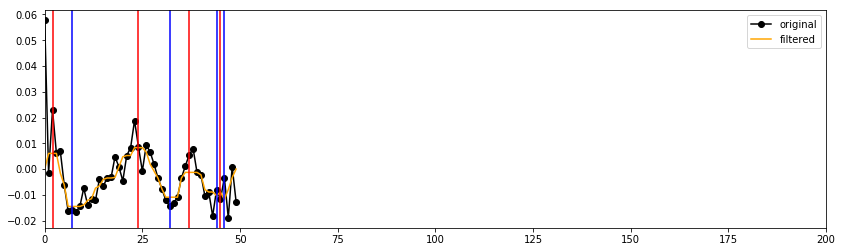

L End reached - +
R End reached - +
Widths: [18, 18, 16]


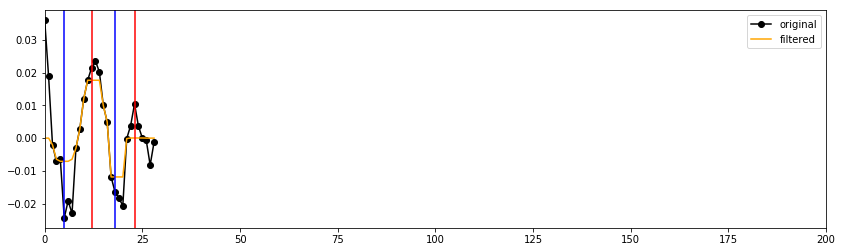

L End reached - +
R End reached + -
Widths: [13, 19, 26, 21]


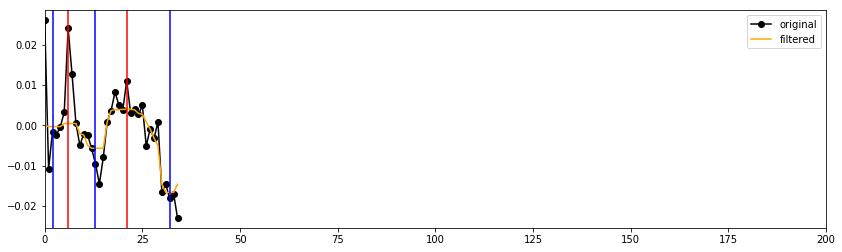

L End reached - +
R End reached - +
Widths: [19]


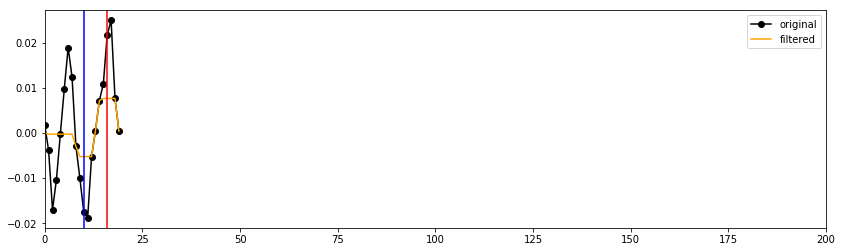

L End reached - +
R End reached - +
Widths: [19, 19, 20, 21, 22, 21, 17, 12, 9]


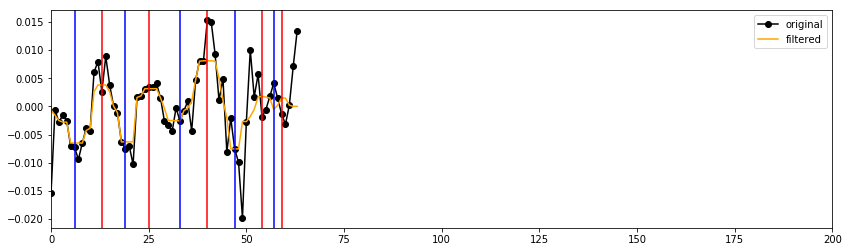

L End reached - +
R End reached - +
Widths: [15, 18, 14, 14, 11]


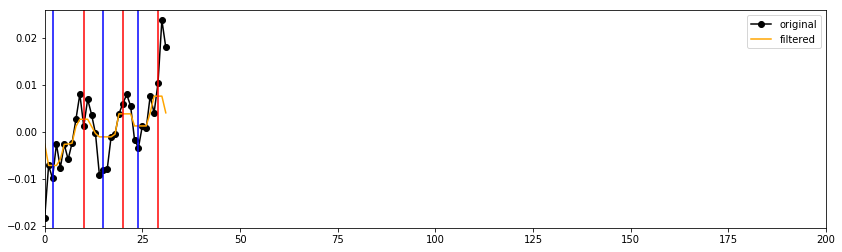

L End reached - +
R End reached + -
Widths: [18, 18, 19, 18]


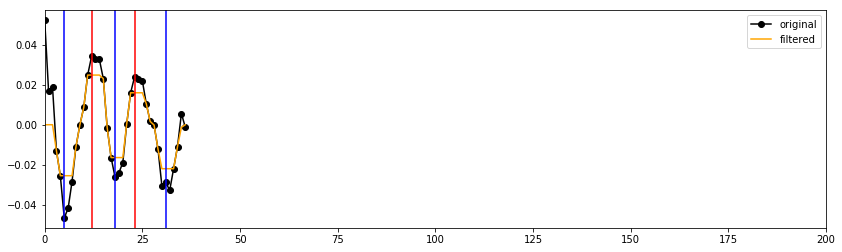

L End reached + -
R End reached - +
Widths: [22, 24, 20, 18, 19, 17, 14, 10]


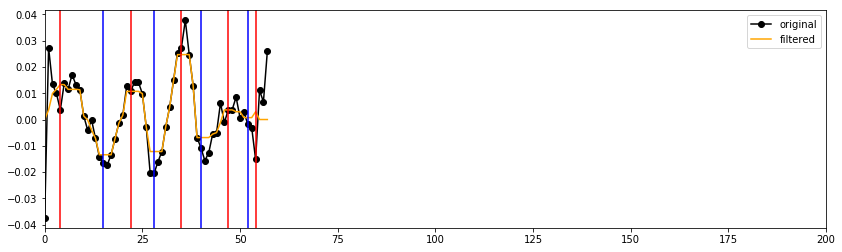

L End reached + -
R End reached + -
Widths: [10, 17, 14, 13, 4, 4, 4, 5, 4, 5, 10, 11, 10, 6, 13, 15, 19, 20, 20]


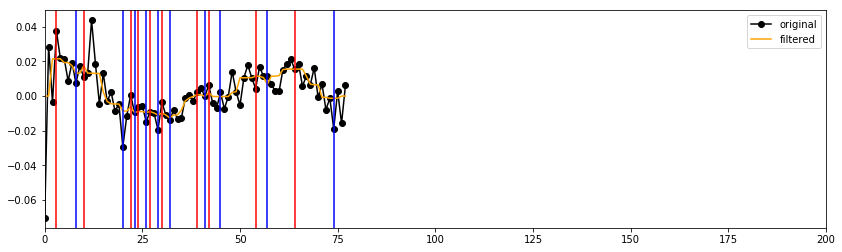

L End reached - +
R End reached - +
Widths: [14, 16, 18, 14, 11]


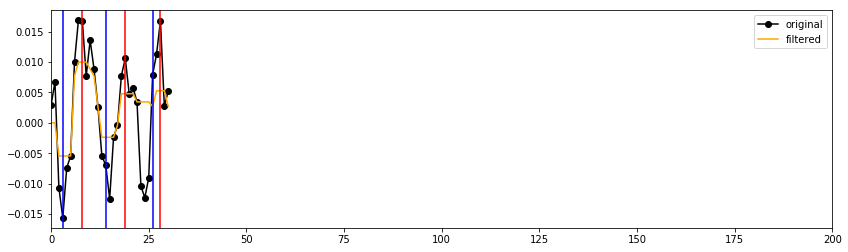

L End reached + -
R End reached - +
Widths: [30, 26, 22, 24]


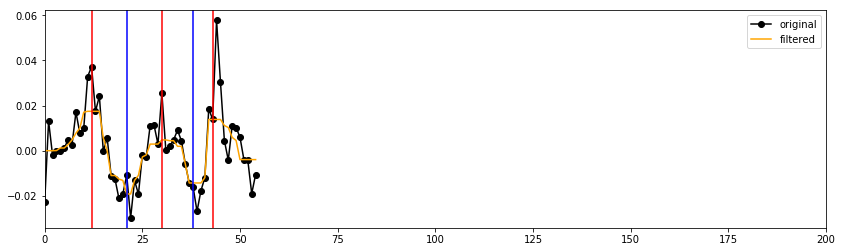

L End reached + -
R End reached - +
Widths: [22, 19, 19, 15]


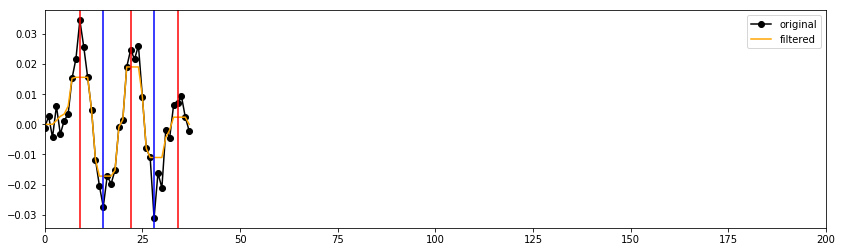

L End reached + -
R End reached + -
Widths: [25]


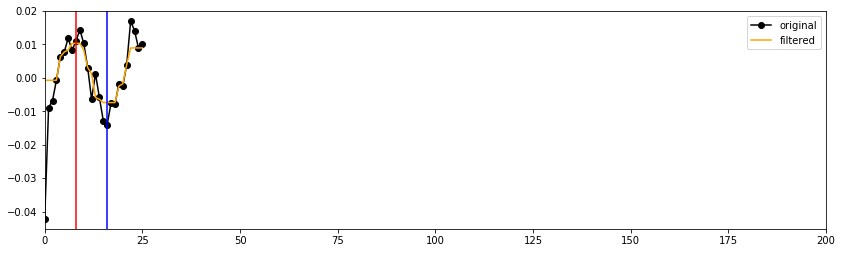

L End reached + -
R End reached + -
Widths: [30, 31, 25]


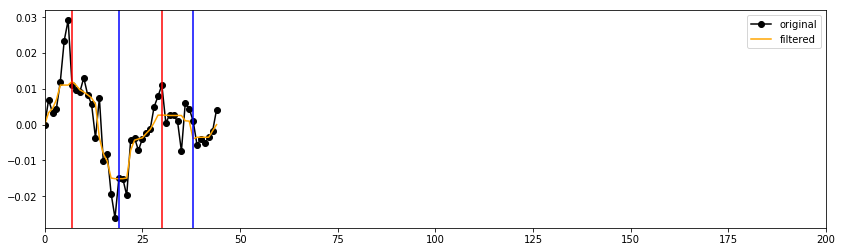

L End reached - +
R End reached + -
Widths: [18, 19, 21, 22]


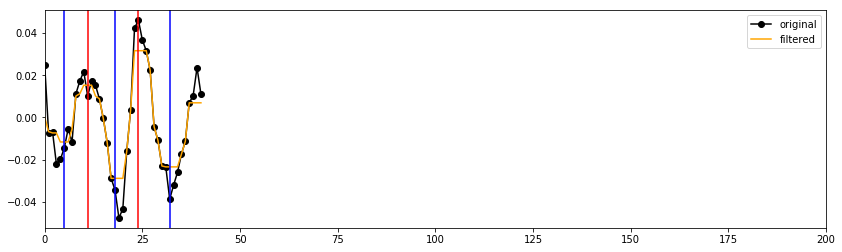

L End reached + -
R End reached - +
Widths: [20, 17, 11, 8, 10, 11]


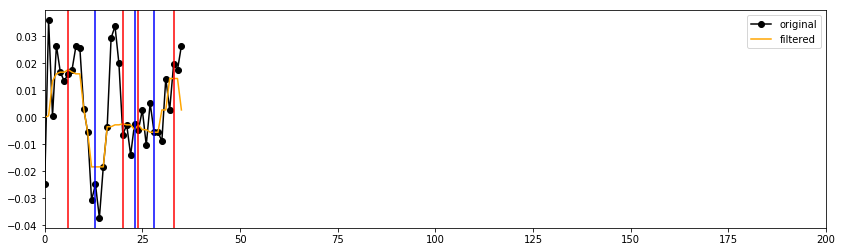

L End reached + -
R End reached + -
Widths: [20, 28, 28, 29, 22]


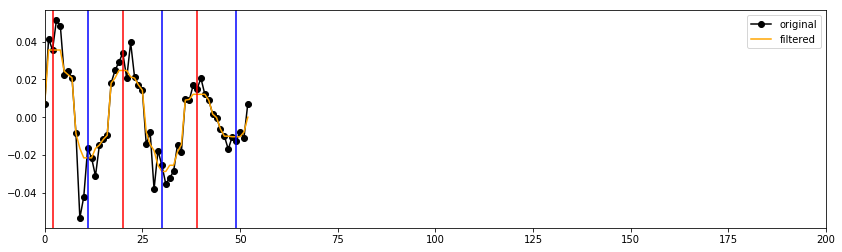

L End reached + -
R End reached + -
Widths: [17]


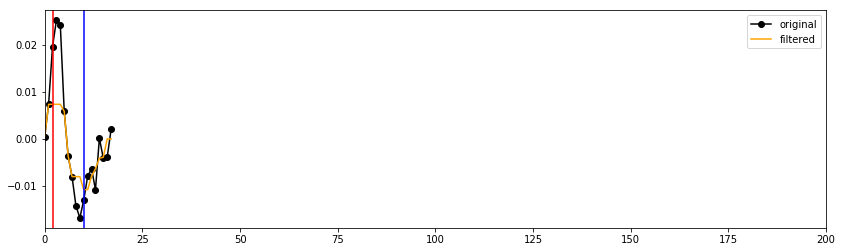

L End reached - +
R End reached - +
Widths: [13, 15, 16, 16, 17, 16, 16]


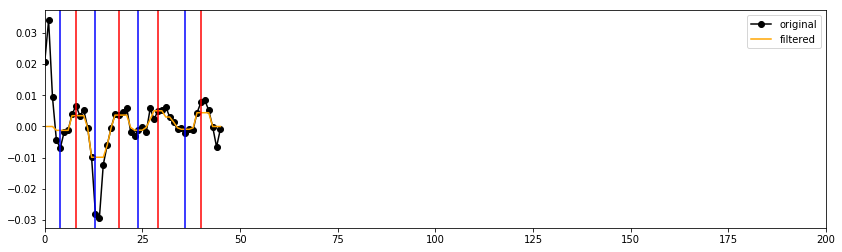

L End reached + -
R End reached + -
Widths: [17, 18, 19, 14, 8, 3, 5]


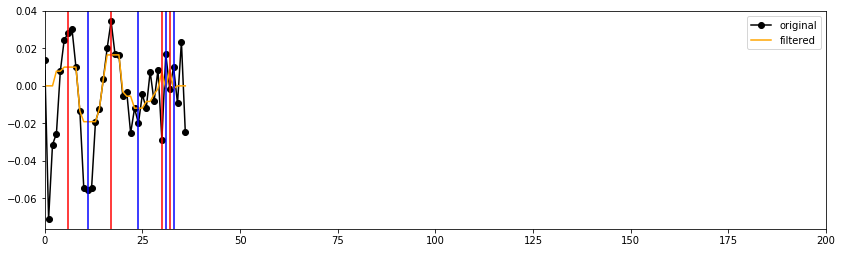

L End reached + -
R End reached + -
Widths: [19, 23, 27]


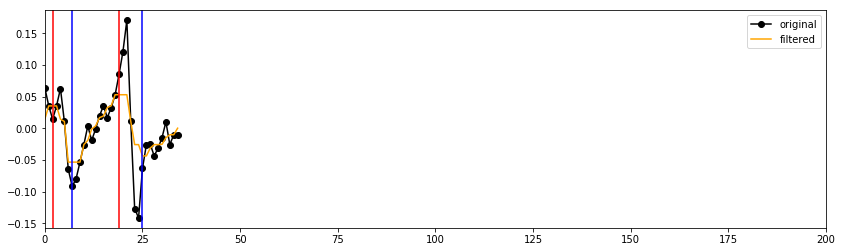

L End reached + -
R End reached - +
Widths: [14, 16, 16, 14]


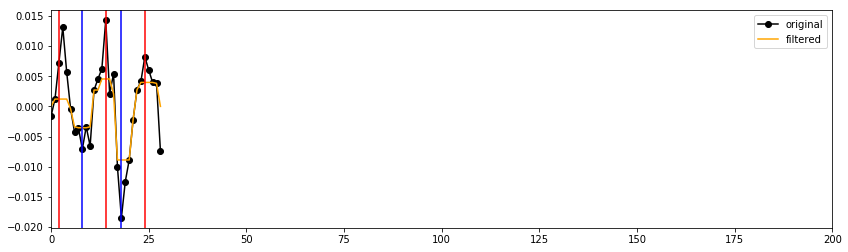

L End reached + -
R End reached - +
Widths: [29, 28]


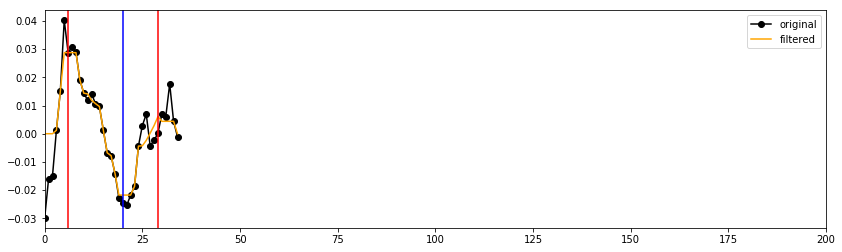

L End reached + -
R End reached + -
Widths: [15, 21, 19]


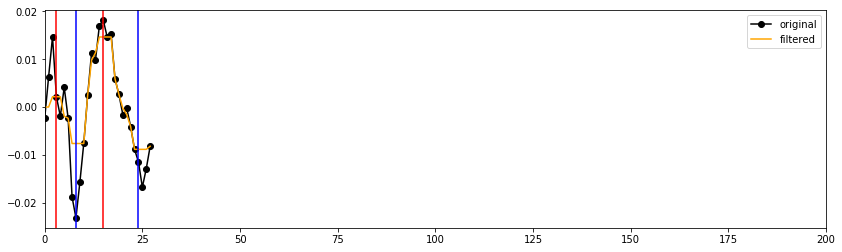

L End reached + -
R End reached + -
Widths: [13]


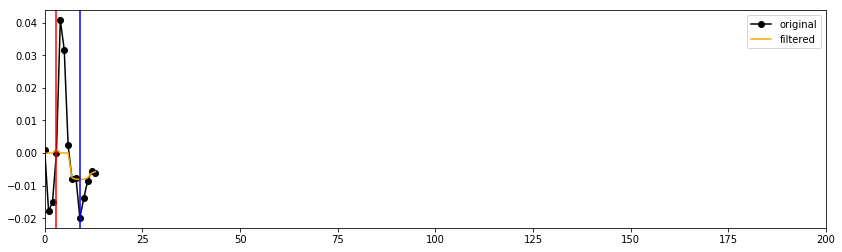

L End reached + -
R End reached + -
Widths: [18, 20, 14]


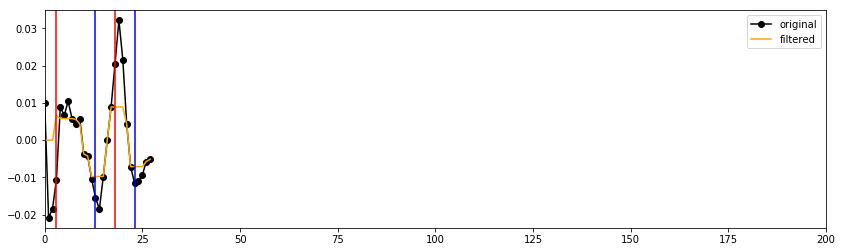

L End reached + -
R End reached - +
Widths: [16, 19, 15, 14]


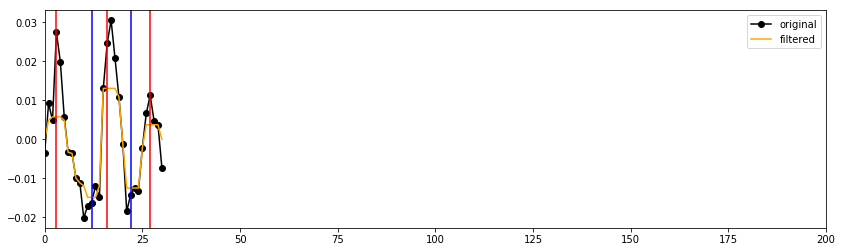

L End reached + -
R End reached - +
Widths: [16, 13, 13, 15, 17, 17, 15, 14]


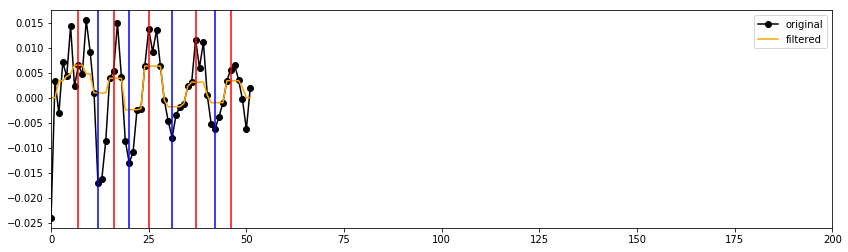

L End reached + -
R End reached + -
Widths: [14, 19, 22]


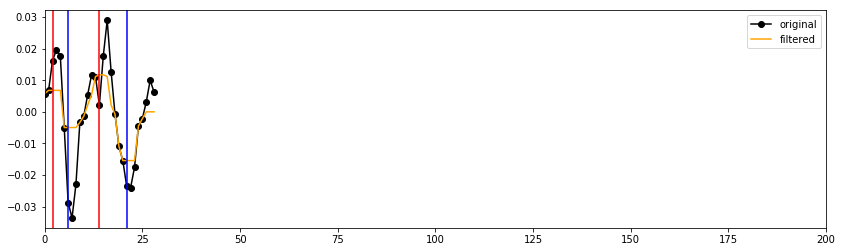

L End reached + -
R End reached - +
Widths: [16, 17]


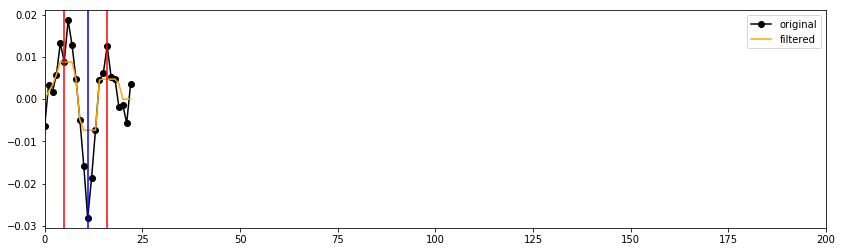

L End reached + -
R End reached - +
Widths: [9, 7, 14, 14, 11, 7]


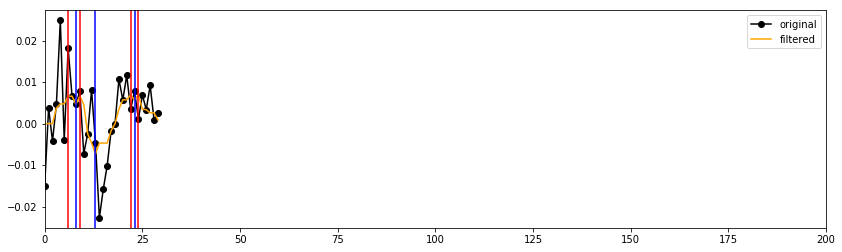

L End reached + -
R End reached + -
Widths: [27, 23, 22]


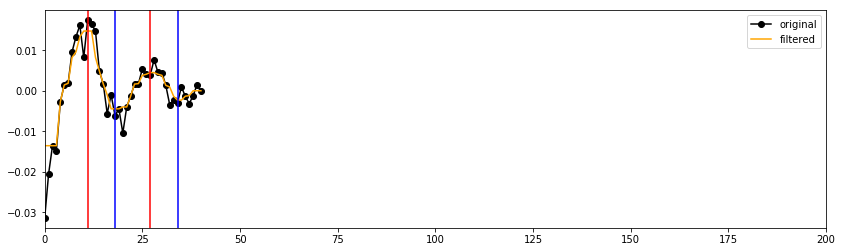

L End reached - +
R End reached - +
Widths: [17, 20, 17]


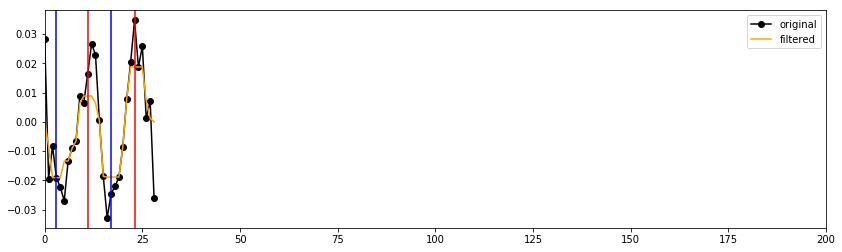

L End reached + -
R End reached - +
Widths: [21, 26, 25, 24]


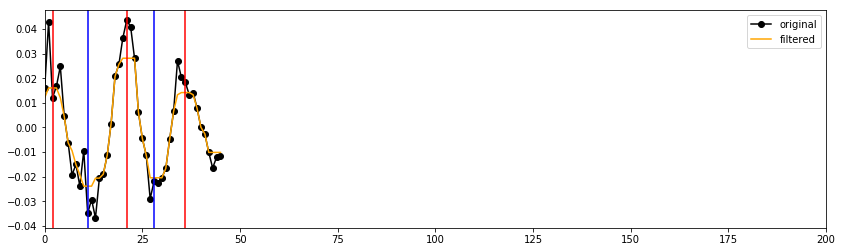

L End reached - +
R End reached - +
Widths: [15, 20, 19, 18, 16]


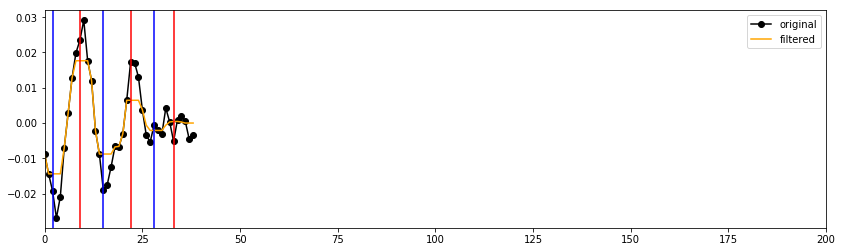

L End reached - +
R End reached + -
Widths: [14, 14, 13, 10]


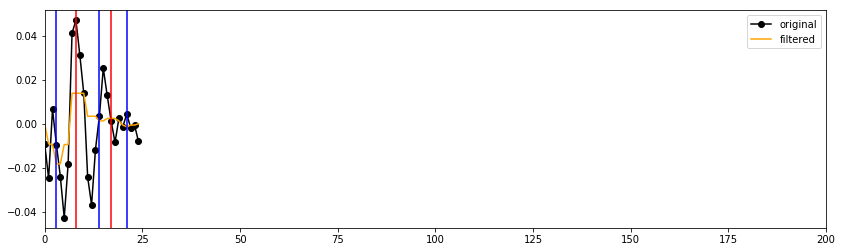

L End reached + -
R End reached + -
Widths: [16, 20, 17, 16, 16, 19, 17]


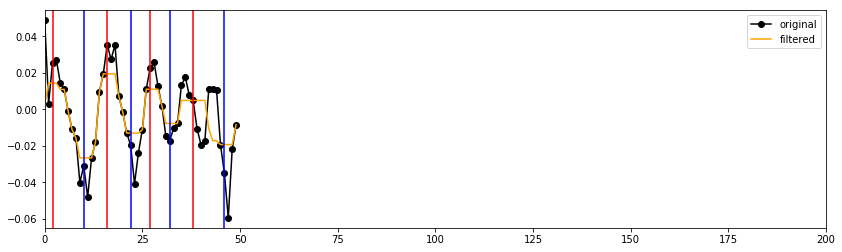

L End reached + -
R End reached - +
Widths: [10, 14]


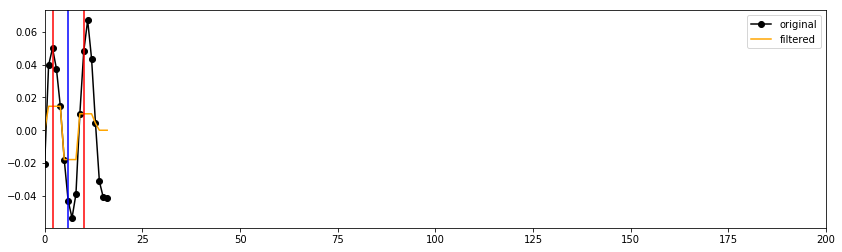

L End reached + -
R End reached - +
Widths: [17, 17, 16, 15, 16, 14]


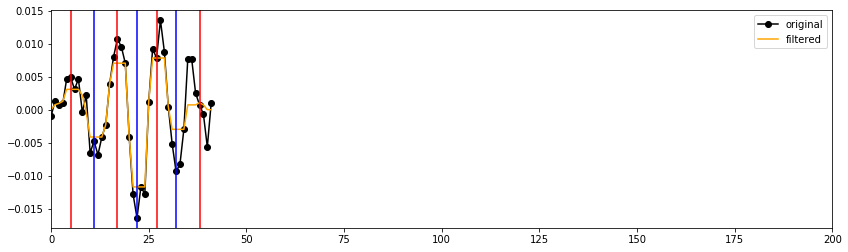

L End reached - +
R End reached + -
Widths: [21, 28]


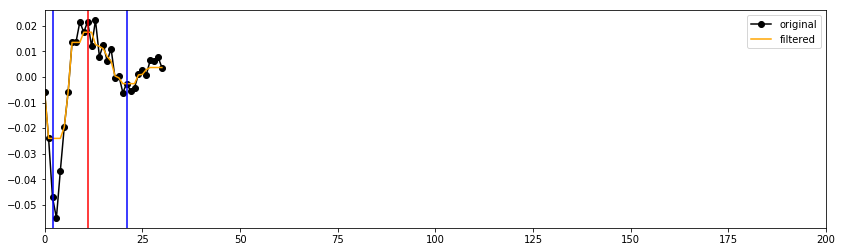

L End reached - +
R End reached + -
Widths: [21, 27, 32, 31, 36, 30, 28, 22, 20, 14]


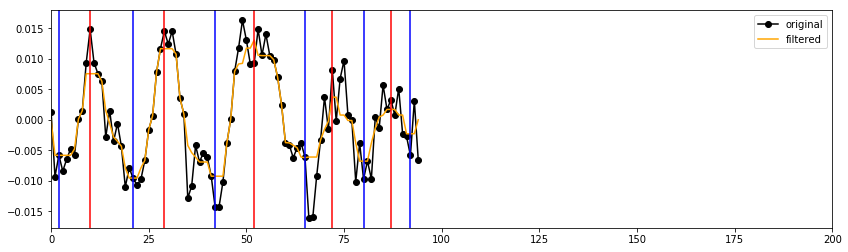

L End reached + -
R End reached - +
Widths: [24, 27]


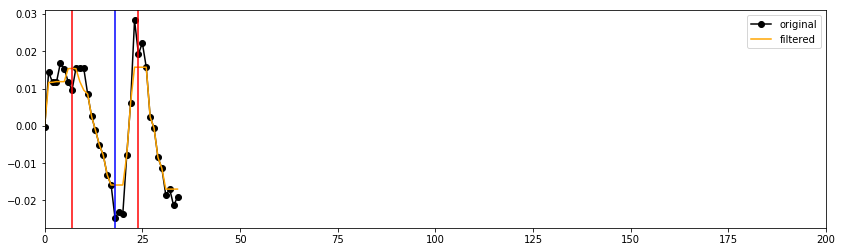

Widths: []


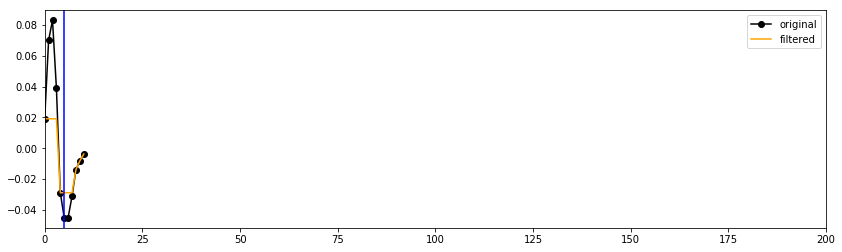

L End reached - +
R End reached - +
Widths: [31, 37, 33]


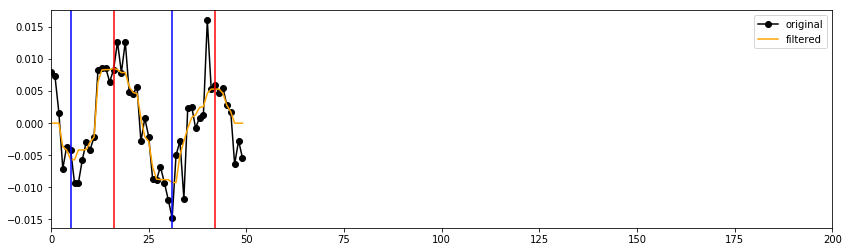

L End reached + -
R End reached + -
Widths: [18, 24, 24, 22, 18]


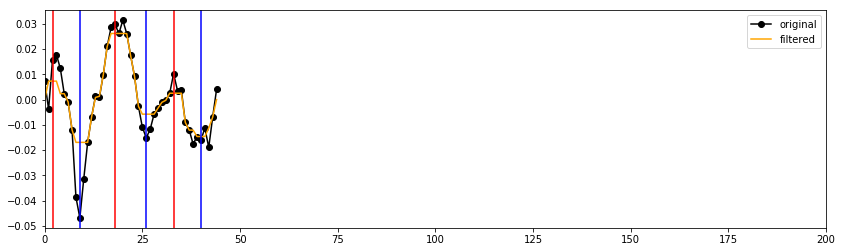

L End reached - +
R End reached + -
Widths: [9, 5, 6, 7]


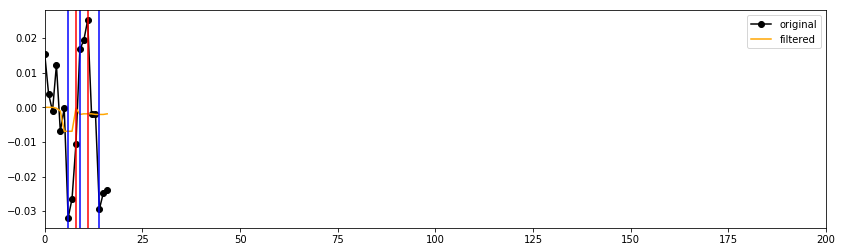

L End reached + -
R End reached + -
Widths: [9, 14, 19]


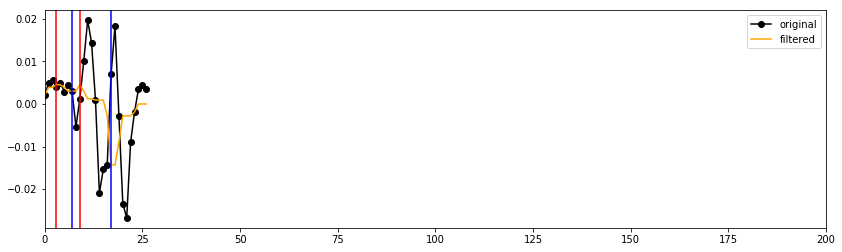

L End reached - +
R End reached - +
Widths: [20, 21, 18, 17, 17]


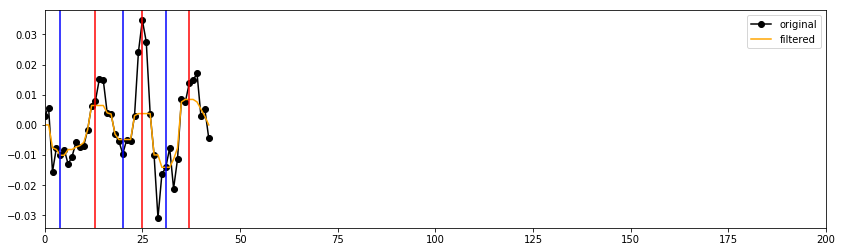

L End reached + -
R End reached + -
Widths: [28, 35, 21]


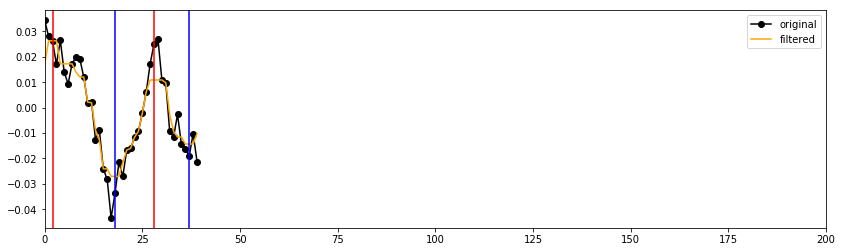

L End reached - +
R End reached - +
Widths: [18, 23, 18, 17, 15]


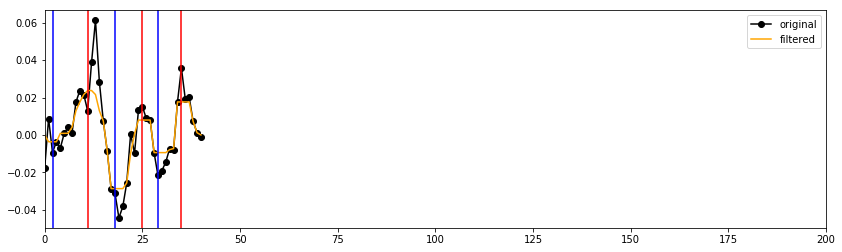

L End reached + -
R End reached - +
Widths: [19, 20]


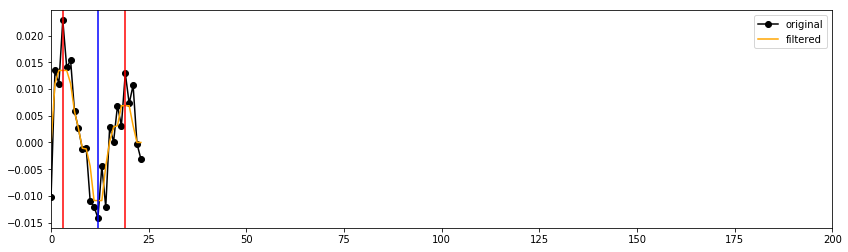

L End reached + -
R End reached + -
Widths: [19]


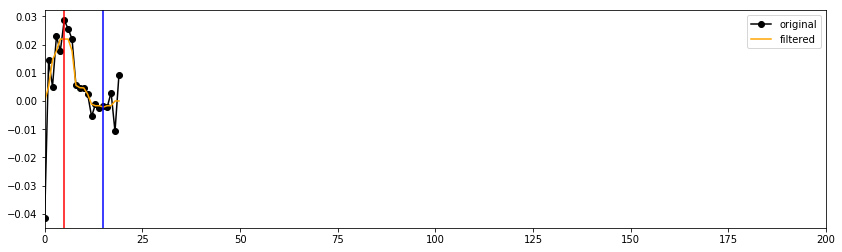

L End reached + -
R End reached + -
Widths: [22, 25, 23, 21, 22, 20, 18]


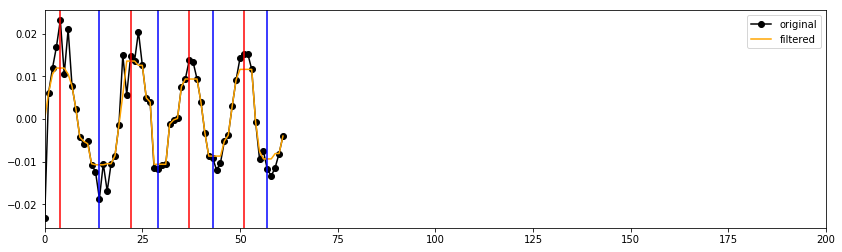

L End reached - +
R End reached + -
Widths: [24, 26]


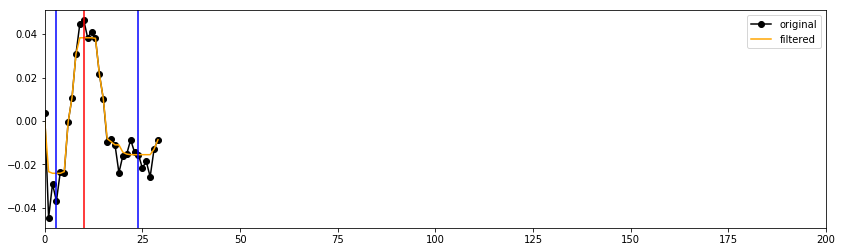

L End reached + -
R End reached + -
Widths: [12, 15, 14]


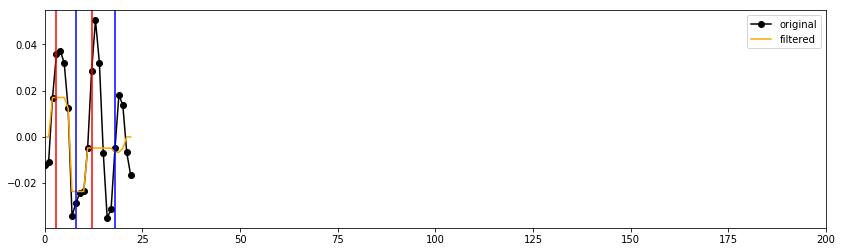

L End reached + -
R End reached - +
Widths: [17, 21, 23, 18]


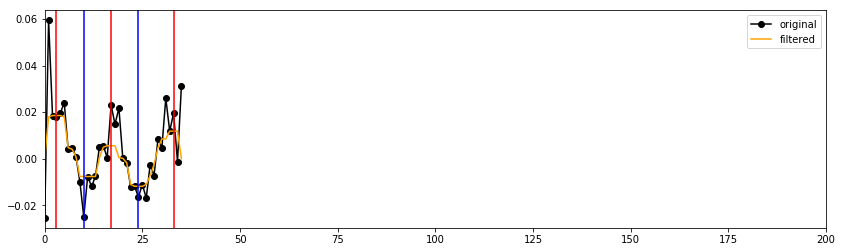

L End reached - +
R End reached + -
Widths: [12, 17, 21, 19]


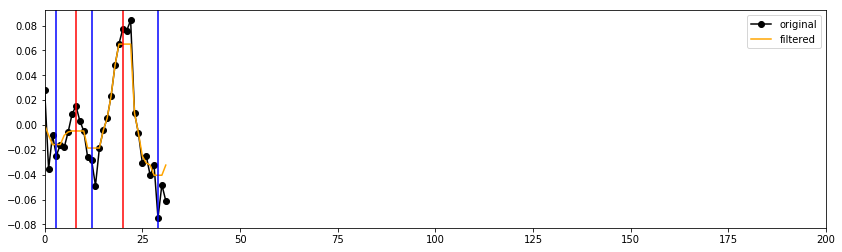

L End reached + -
R End reached + -
Widths: [22]


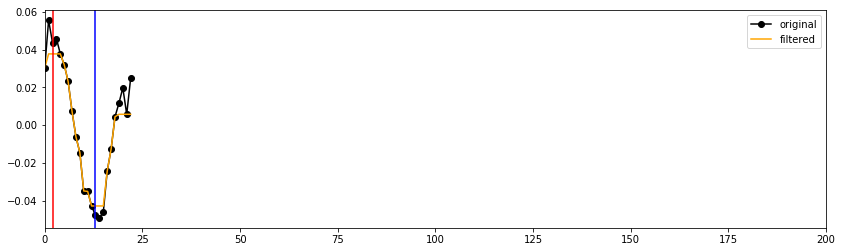

L End reached - +
R End reached - +
Widths: [25, 26, 26, 24, 27, 26, 27]


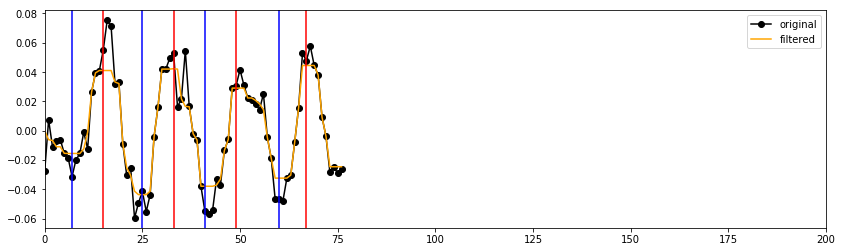

L End reached + -
R End reached - +
Widths: [19, 18, 15, 10]


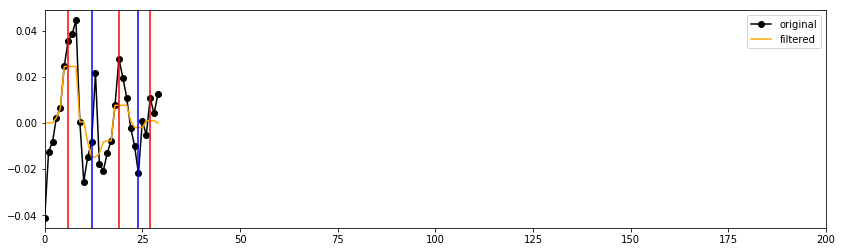

L End reached + -
R End reached + -
Widths: [19, 22, 20]


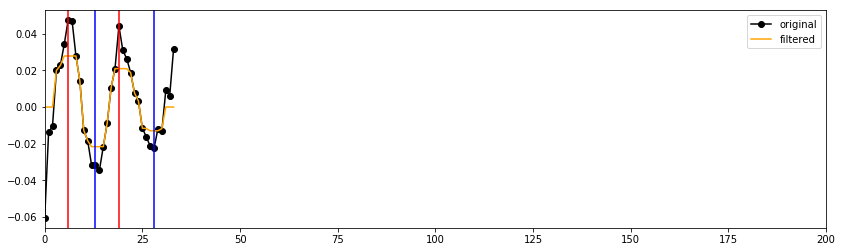

L End reached + -
R End reached + -
Widths: [12, 14, 16]


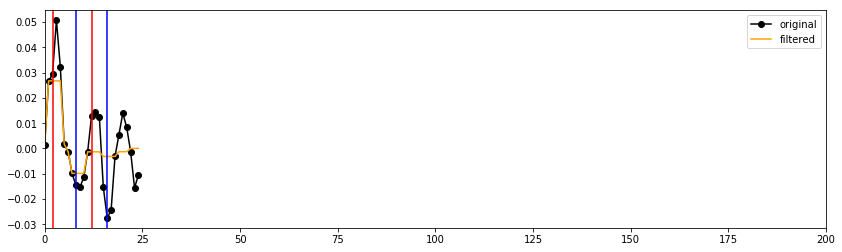

L End reached - +
R End reached + -
Widths: [35, 26, 19, 19]


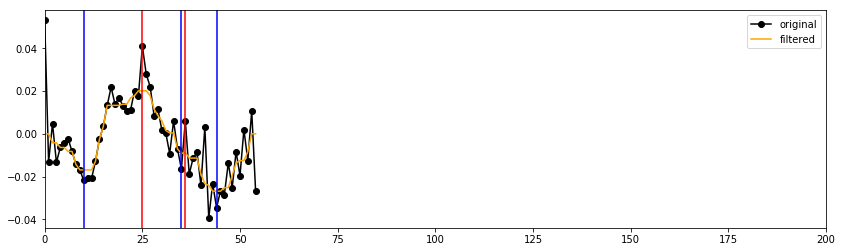

L End reached + -
R End reached - +
Widths: [17, 19, 20, 20, 23, 17]


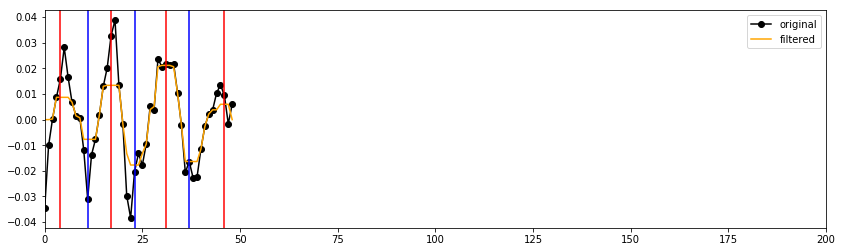

L End reached - +
R End reached + -
Widths: [12, 17, 15, 16]


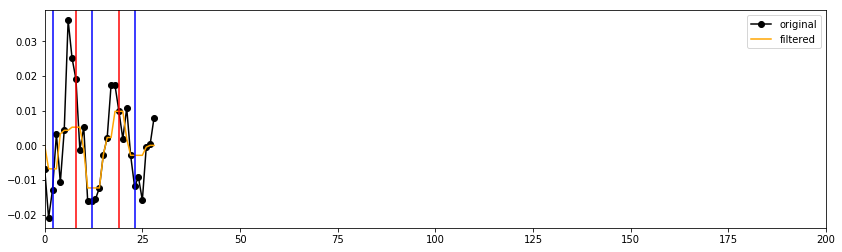

L End reached + -
R End reached + -
Widths: [19]


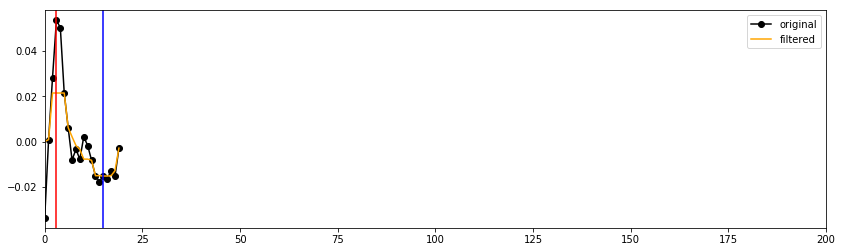

L End reached + -
R End reached + -
Widths: [19, 12, 6, 6, 6, 11, 13]


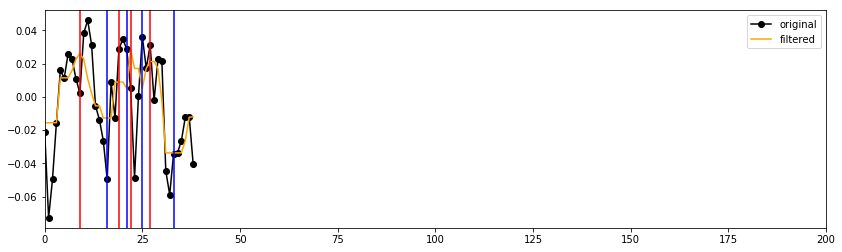

L End reached - +
R End reached - +
Widths: [16, 18, 19]


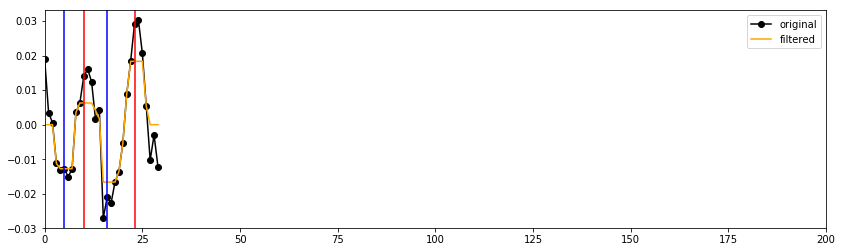

Widths: []


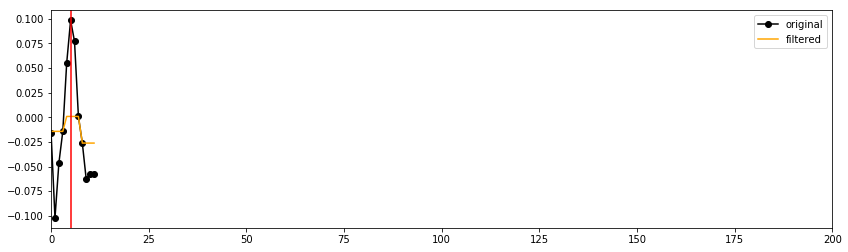

L End reached + -
R End reached - +
Widths: [19, 18, 17, 20]


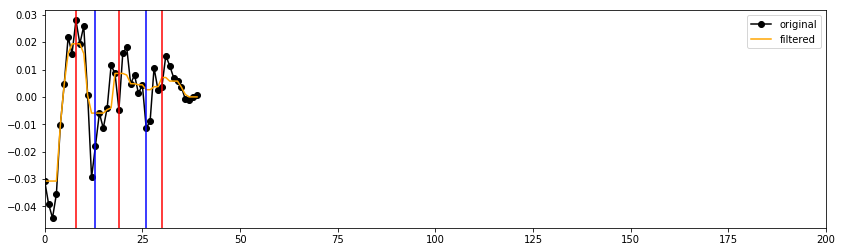

L End reached + -
R End reached + -
Widths: [12, 19, 20, 20, 16, 16, 14]


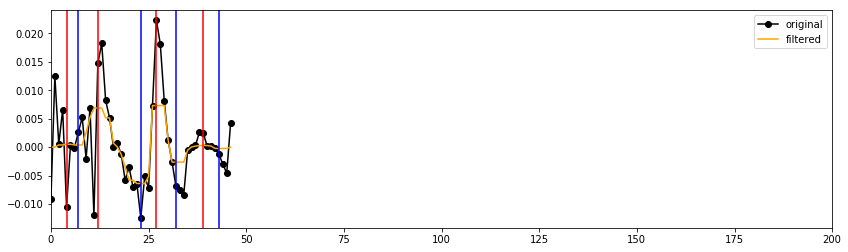

L End reached + -
R End reached - +
Widths: [20, 17]


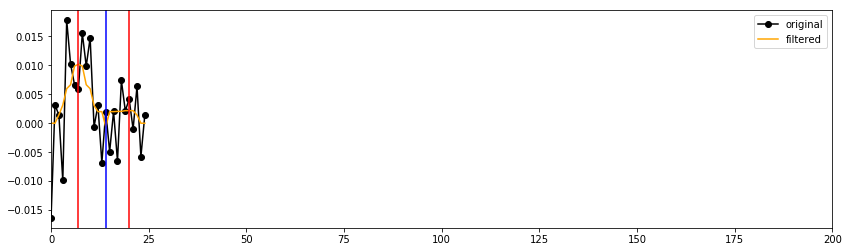

L End reached - +
R End reached - +
Widths: [16]


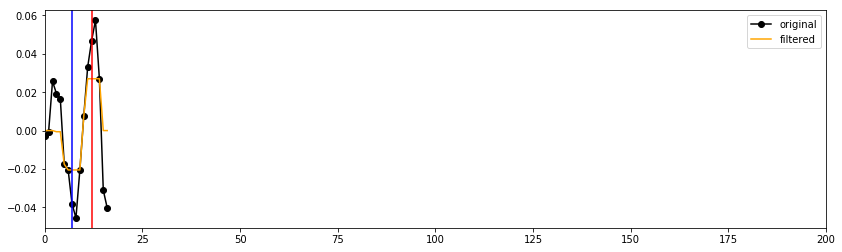

L End reached + -
R End reached - +
Widths: [19, 19, 21, 16]


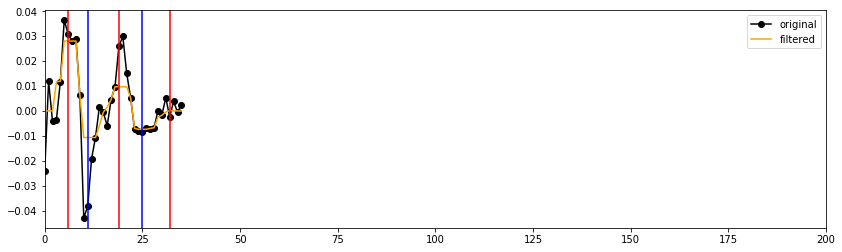

L End reached + -
R End reached + -
Widths: [31]


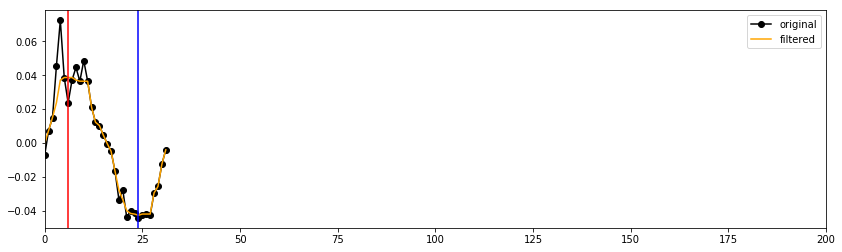

L End reached - +
R End reached + -
Widths: [20, 25, 26, 19]


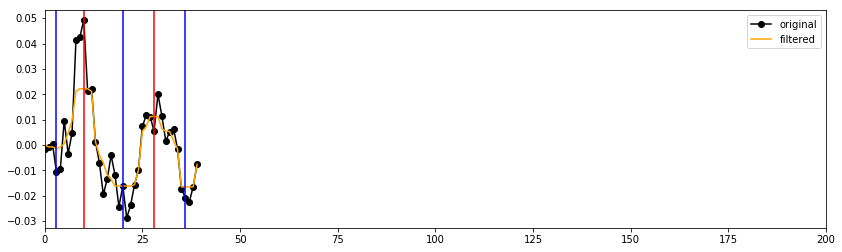

L End reached - +
R End reached - +
Widths: [17]


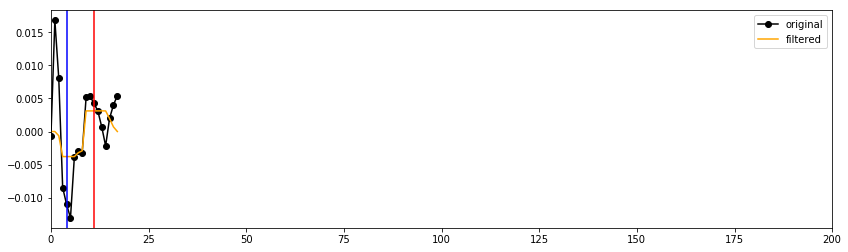

L End reached + -
R End reached + -
Widths: [15, 20, 21, 19, 16, 15, 12]


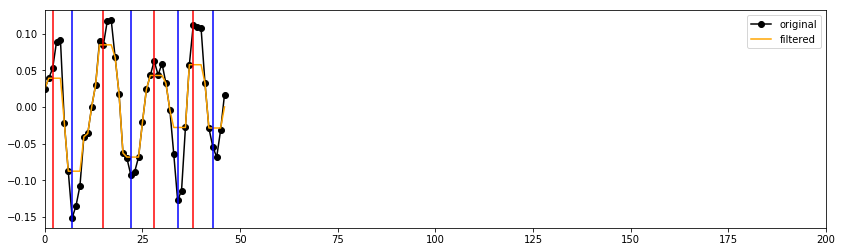

L End reached - +
R End reached - +
Widths: [14, 13, 12]


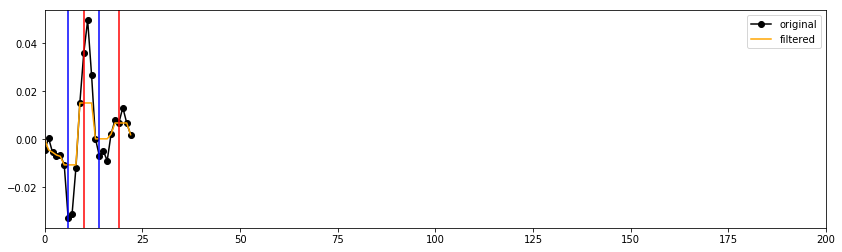

L End reached + -
R End reached + -
Widths: [21, 24, 24, 21, 19]


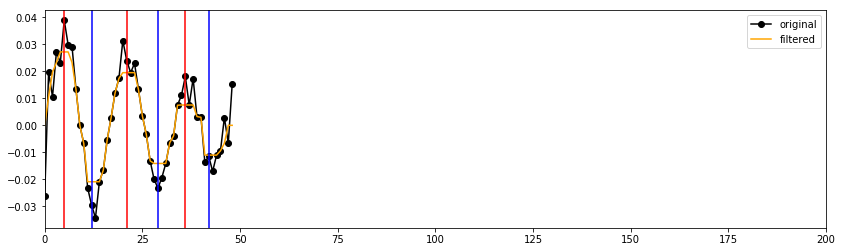

L End reached + -
R End reached + -
Widths: [24]


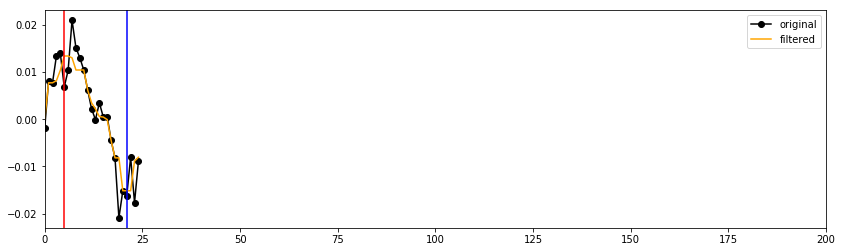

L End reached + -
R End reached + -
Widths: [16]


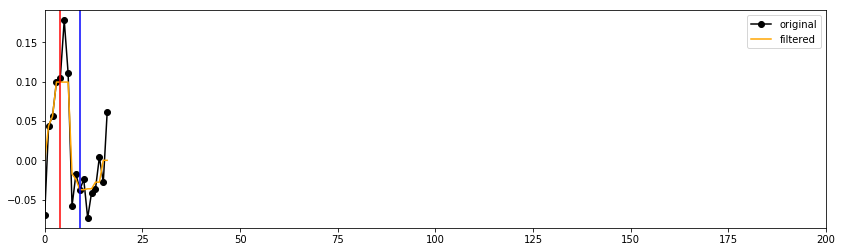

L End reached + -
R End reached - +
Widths: [19, 22, 25, 20, 20, 14]


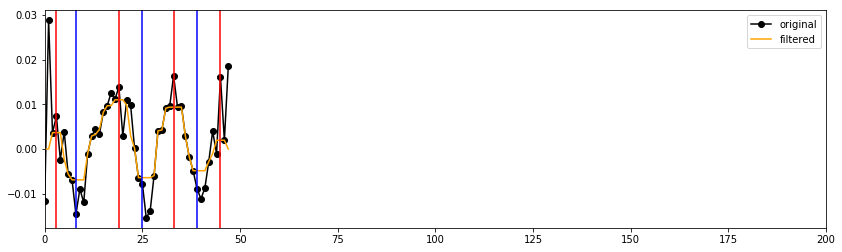

L End reached + -
R End reached + -
Widths: [15]


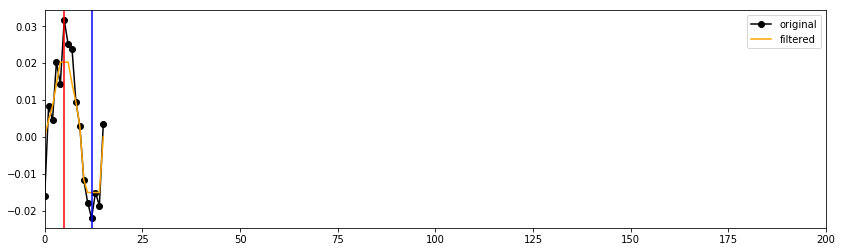

L End reached + -
R End reached - +
Widths: [21, 24, 23, 21, 22, 20]


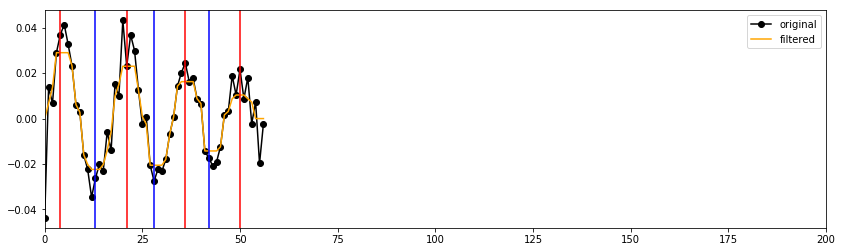

L End reached - +
R End reached + -
Widths: [11, 13, 14, 15, 16, 18, 15, 11, 7, 7]


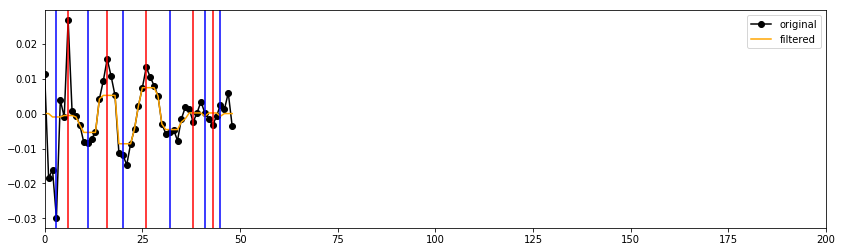

L End reached + -
R End reached + -
Widths: [16, 22, 24, 24, 23, 22, 22]


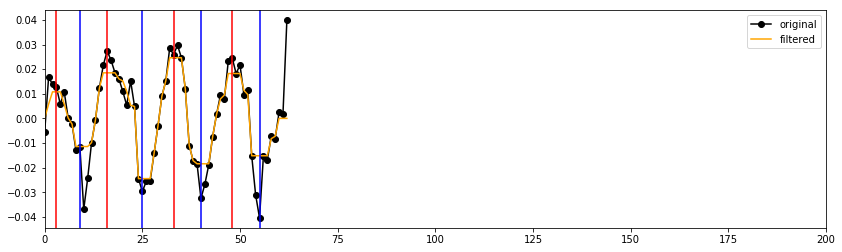

L End reached - +
R End reached + -
Widths: [17, 21, 20, 21, 19, 22, 21, 20, 18, 18]


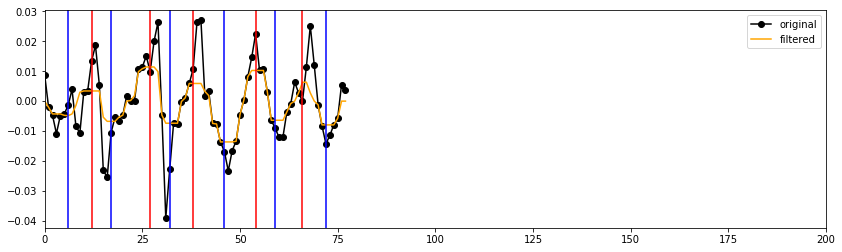

L End reached - +
R End reached + -
Widths: [12, 14, 14, 14]


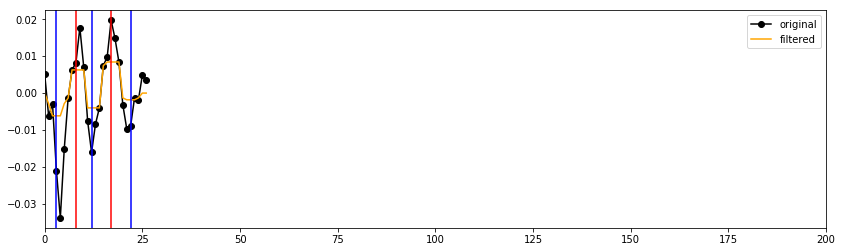

L End reached + -
R End reached - +
Widths: [16, 22, 20, 21]


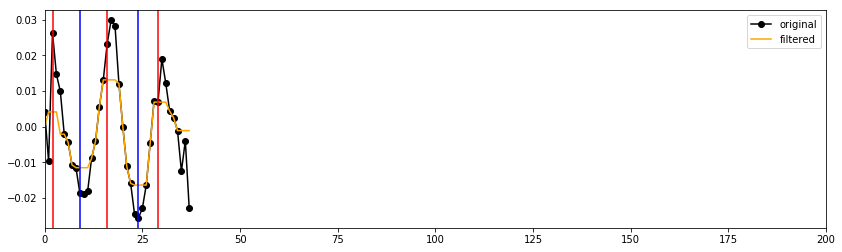

L End reached + -
R End reached + -
Widths: [30]


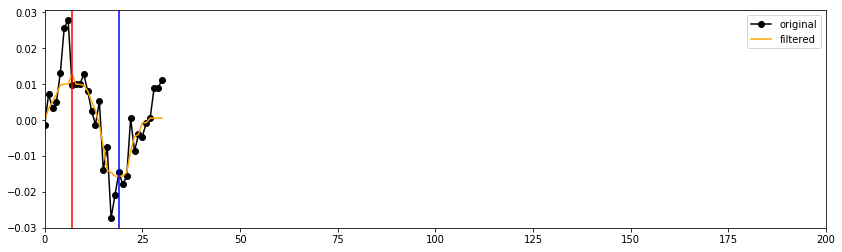

L End reached + -
R End reached + -
Widths: [19, 25, 27, 25, 20]


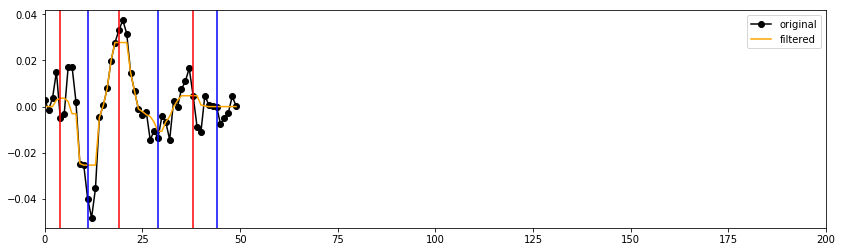

L End reached + -
R End reached + -
Widths: [26, 22, 16, 7, 5, 12, 11]


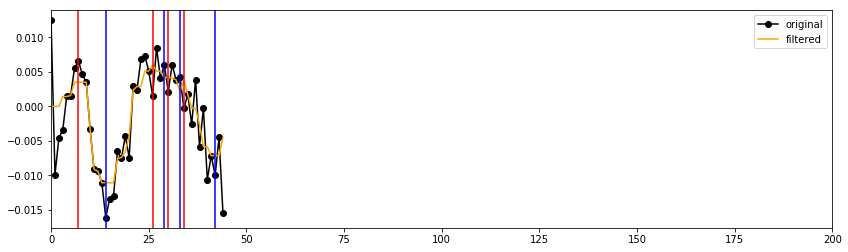

Widths: []


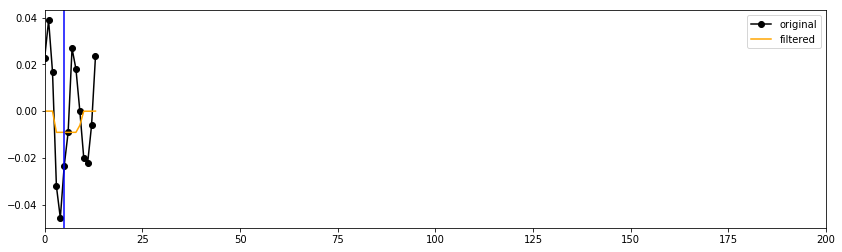

L End reached + -
R End reached - +
Widths: [17, 14, 12, 7]


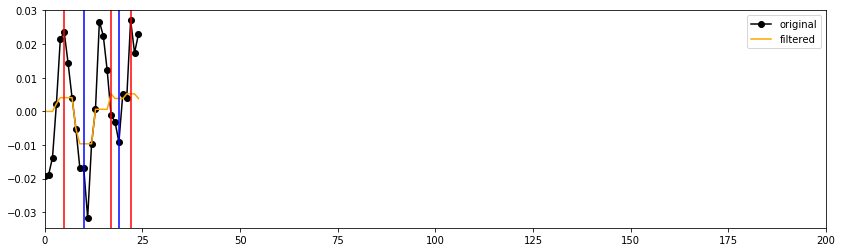

L End reached - +
R End reached - +
Widths: [15, 16, 15, 14, 13]


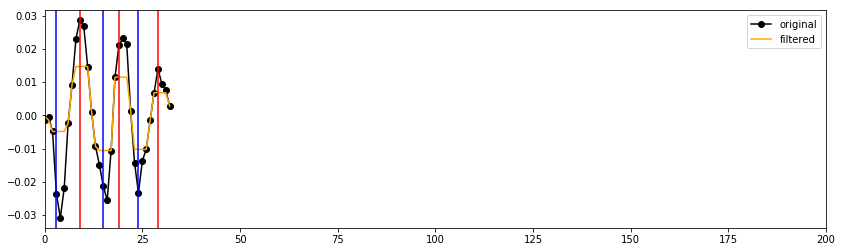

L End reached - +
R End reached + -
Widths: [16, 16, 16, 15, 15, 14]


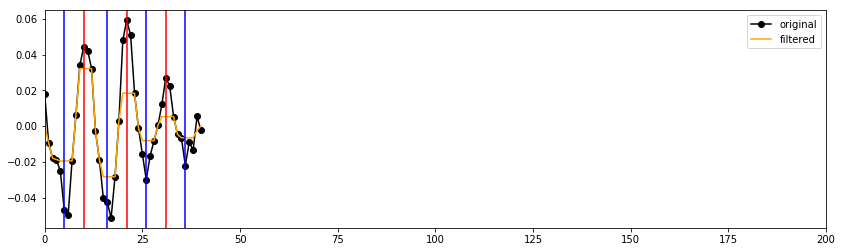

Ends reached 300 times
L End reached + -
R End reached - +
Widths: [26, 23, 19, 19, 20, 16, 6, 4, 3, 4, 5, 5, 4, 3, 8, 9, 9, 9, 12, 18, 20, 18, 17, 18, 16, 17, 10, 10, 8, 11]


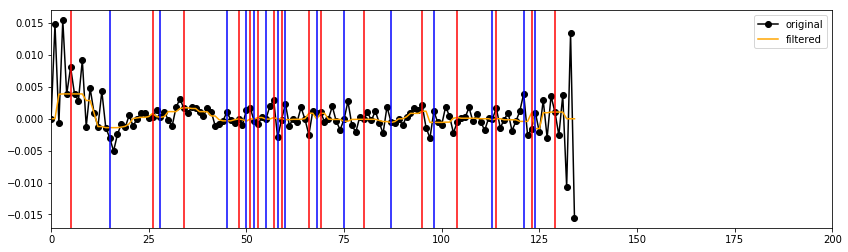

L End reached + -
R End reached + -
Widths: [7, 3, 4, 11, 16, 27, 21, 16, 5, 4, 5, 9, 11]


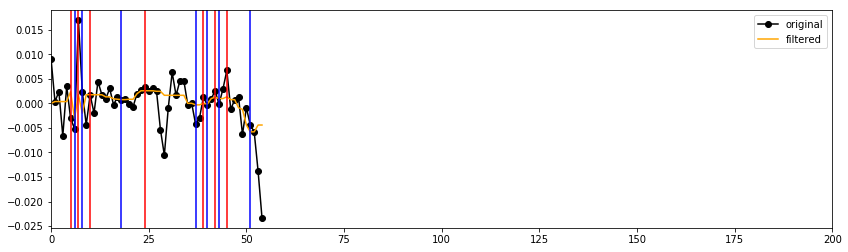

L End reached + -
R End reached + -
Widths: [7, 7, 6, 6, 6, 8, 6, 7, 13, 15, 14, 7, 5, 9, 15, 17, 18]


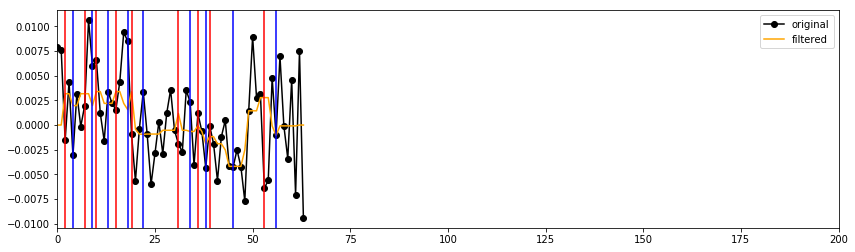

L End reached + -
R End reached + -
Widths: [18, 10, 5, 7, 8, 8, 7, 6, 6, 6, 7, 7, 7, 9, 7, 9, 6, 9, 7, 7, 7, 7, 9, 7, 9, 24, 25]


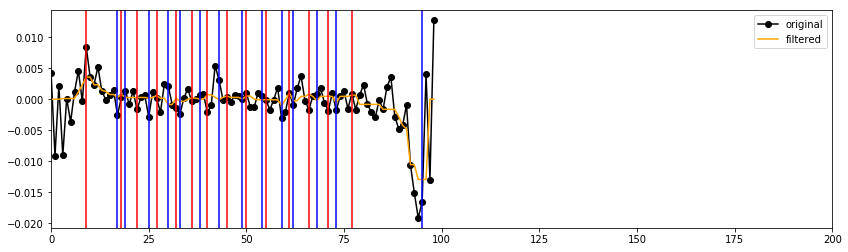

L End reached + -
R End reached - +
Widths: [14, 8, 7, 7, 6, 6, 13, 18, 23, 20, 29, 24, 31, 22, 33, 23]


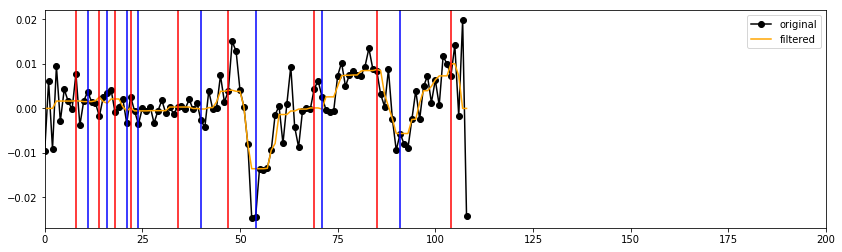

L End reached + -
R End reached + -
Widths: [7, 7, 6, 6, 6, 8, 6, 8, 13, 26, 30, 25, 12, 18, 17, 18, 10]


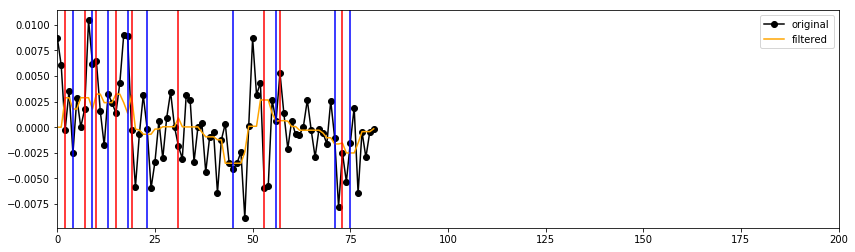

L End reached - +
R End reached + -
Widths: [8, 17, 21, 24, 15, 14, 15, 15, 10, 6, 13, 12, 14, 12, 13, 14]


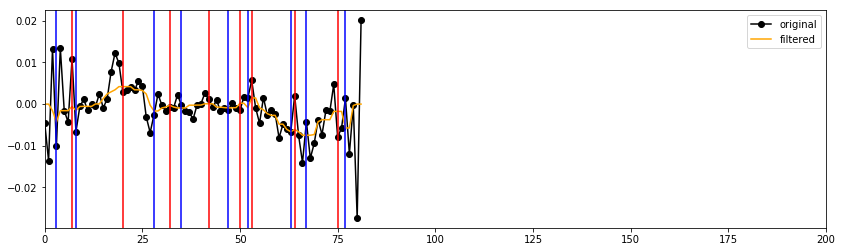

L End reached + -
R End reached + -
Widths: [14, 16, 17, 19, 18, 11, 7, 9, 12, 12, 7, 5, 9, 14, 17, 14, 10, 8, 7, 12, 14, 25, 21, 18, 7, 5, 6, 7, 7, 10, 20, 20, 15, 7, 9]


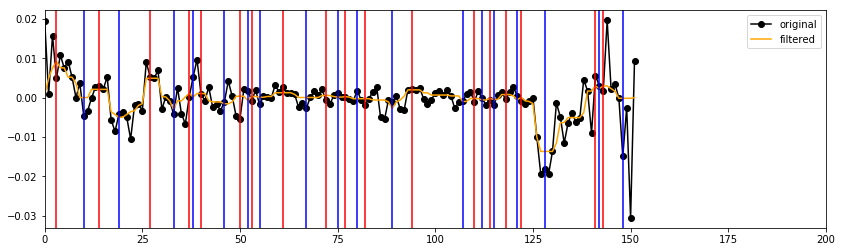

L End reached - +
R End reached + -
Widths: [20, 21, 17, 15, 20, 16, 11, 10, 13, 12, 8, 7, 7, 7, 7, 15, 15, 14, 6, 7, 6, 12, 10, 10, 7, 11, 18, 16, 28, 22, 21, 6, 9, 12, 10, 7, 4, 4, 9, 16, 17, 12, 7, 9, 13, 22, 22, 18, 7, 6]


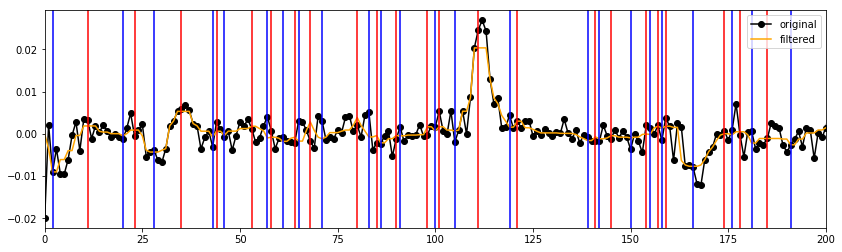

L End reached - +
R End reached + -
Widths: [7, 7, 13, 22, 21, 21, 14, 13, 9, 7, 7, 11, 15, 16, 10, 9, 7, 8]


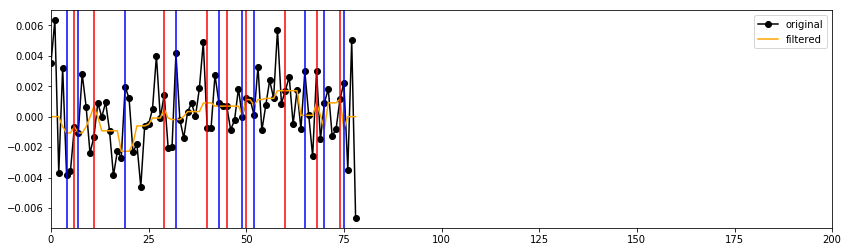

L End reached + -
R End reached + -
Widths: [20, 22, 23, 15, 21, 29, 31, 24, 19, 27, 25]


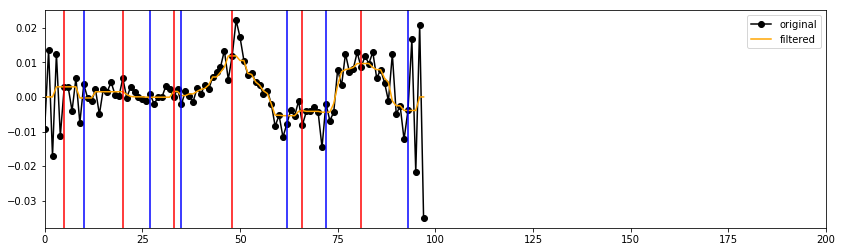

L End reached + -
R End reached + -
Widths: [6, 4, 4, 4, 4, 7, 20, 28, 27, 14, 7, 10, 10, 10, 9, 10, 16, 18, 24, 28, 23, 22, 16, 17, 10, 5, 4, 4, 5, 4, 5, 4, 4, 4, 4, 5, 14]


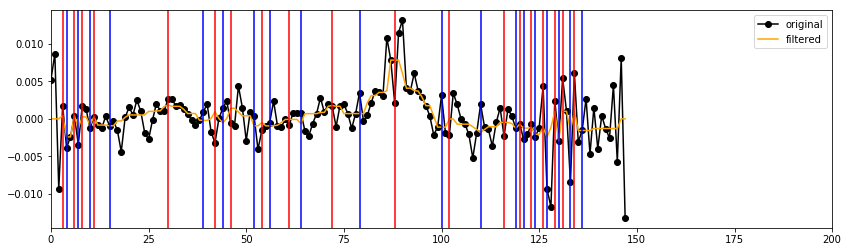

L End reached - +
R End reached + -
Widths: [19, 19, 12, 12, 18, 21, 21, 12, 8, 9, 15, 18, 15, 10, 11, 11, 12, 7, 15, 19, 22, 16, 14, 18, 19, 15, 8, 7, 10, 10, 7, 6, 7, 8, 6, 4, 4, 4, 6, 6, 7, 6, 8, 11, 10, 9, 8, 9, 7, 6, 7, 13, 14, 13, 23, 24]


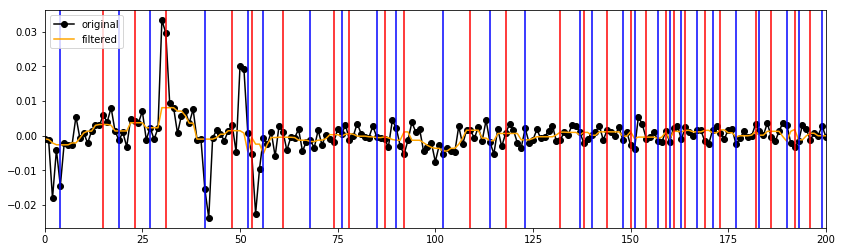

L End reached + -
R End reached - +
Widths: [8, 6, 4, 11, 16, 15, 9, 6, 9, 8, 7, 4, 7, 11, 12, 9, 18, 27, 29, 16, 8, 6, 9, 11, 15, 17, 20, 20]


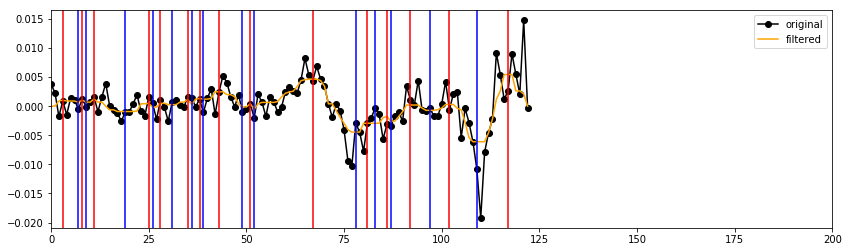

L End reached + -
R End reached + -
Widths: [8, 8, 14, 33, 36, 30, 11, 7, 6, 7, 10, 11, 10, 6, 8, 15, 20, 17, 14, 13, 14, 15, 12, 10, 16, 20, 21, 9, 6, 7, 7, 5, 9, 17, 21, 17, 9, 8, 7, 9, 8, 7, 6, 9, 9, 10, 14, 16, 14, 9, 7, 9, 7]


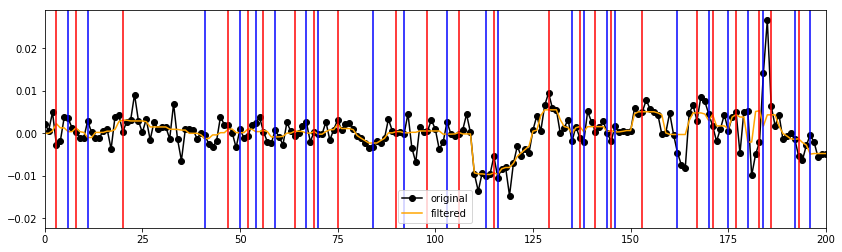

L End reached + -
R End reached + -
Widths: [15, 14, 18, 18, 17, 4, 4, 7, 9, 11, 8, 7, 7, 8, 6, 13, 16, 21, 26, 32, 32, 19, 9, 7, 7, 8, 8]


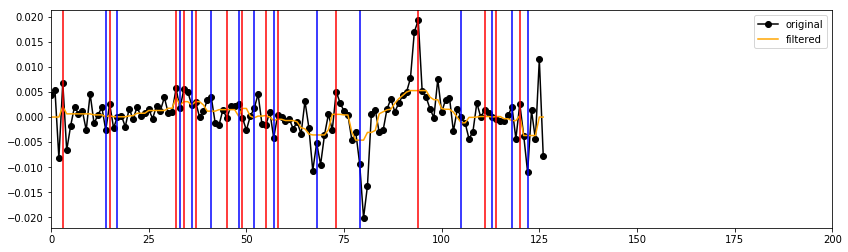

L End reached + -
R End reached - +
Widths: [9, 7, 6, 4, 5, 5, 14, 18, 20, 12, 17, 16, 16, 7, 6, 6, 12, 13, 13, 7, 8, 8, 7, 4, 4, 5, 6, 9, 11, 11, 10, 15, 14, 11, 4, 4, 4, 4, 4, 11, 12, 12, 6, 6, 7, 7, 6, 7, 7, 8, 7, 8, 7, 7, 6, 7, 9, 12]


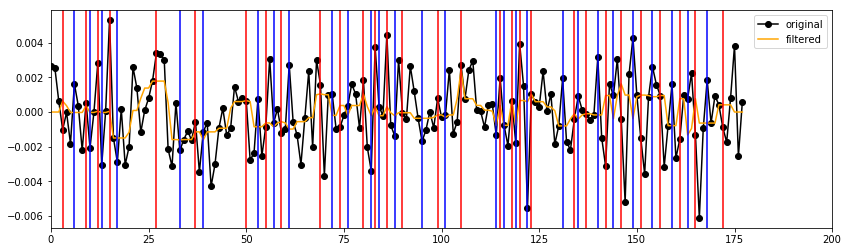

L End reached - +
R End reached + -
Widths: [22, 18, 14, 7, 8, 13, 22, 22, 14, 7, 13, 16, 14, 13, 14, 18, 13, 10, 14, 18, 22, 13, 9, 9, 13, 17, 16, 13, 13, 15, 14, 13, 14, 16, 14, 8, 7, 15, 17, 24, 16, 14, 7, 13, 15, 20, 26, 28, 28, 17, 14, 10, 14, 19, 36, 35, 29, 18, 16, 22, 18, 18, 17, 18, 25, 22, 21, 16, 18, 19, 13, 8, 4, 4, 4, 4, 4, 10, 20, 22, 18, 8, 7, 15, 14, 16, 12, 13, 11, 20, 24, 25, 11, 11, 12, 12, 8, 10, 22, 27, 35, 26, 23, 13, 23, 25, 30, 16, 15, 12, 18, 18, 14, 9, 7, 7, 7, 9, 13, 13, 10, 6, 14, 19, 18, 11, 10, 15, 17, 18, 15, 16, 15, 19, 20, 29, 28, 28, 15, 12, 6, 7, 10, 16, 23, 27, 22, 13, 5, 5, 7, 10, 20, 26, 27, 21, 14, 11, 6, 6, 14, 20, 28, 23, 19, 16, 15, 17, 15, 12, 8, 12, 17, 27, 21, 18, 12, 16, 16, 18, 13, 14, 12, 12, 9, 5, 12, 17, 19, 17, 16, 19, 13, 8, 3, 3, 3, 5]


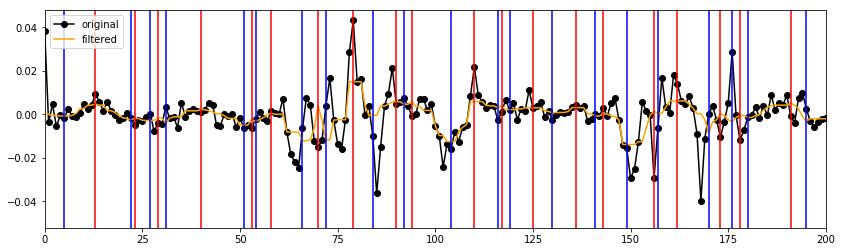

L End reached + -
R End reached + -
Widths: [11, 13, 12, 7, 6, 8, 8, 7, 7, 8, 8, 12, 10, 17, 14, 19, 11, 10, 9]


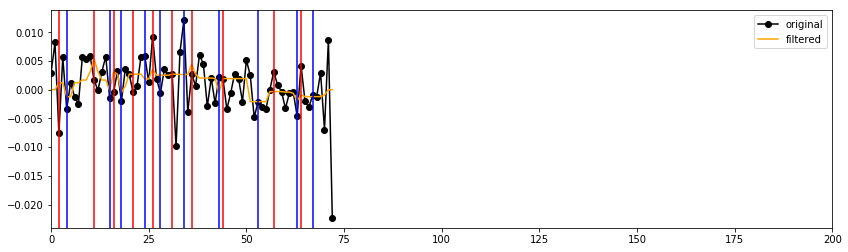

L End reached + -
R End reached - +
Widths: [7, 6, 16, 16, 20, 19, 25, 25, 16, 11, 8, 20, 28, 31, 19, 10, 6, 7, 7, 7, 12, 13, 21, 16, 16, 15, 13, 13, 6, 7, 7, 7, 7, 7, 7, 7]


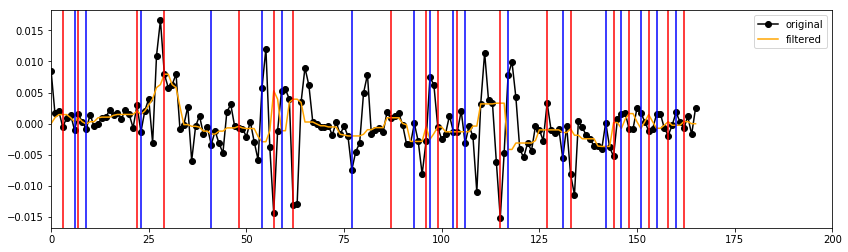

L End reached + -
R End reached + -
Widths: [13, 13, 7, 8, 7, 6, 10, 13, 14, 7, 9, 15, 18, 14, 8, 6, 7, 7, 7, 13, 14, 14, 7, 5, 7, 16, 17, 15, 6, 6, 13, 13, 13, 6, 7, 8, 7, 7, 6, 14, 20, 32, 27, 20, 13, 20, 20, 15, 5, 9, 11, 16, 18]


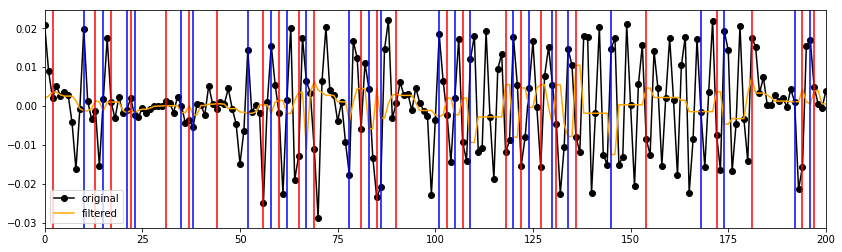

L End reached + -
R End reached + -
Widths: [21, 24, 19, 12, 8, 8, 12, 22, 20, 15, 6, 6, 7, 12, 22, 28, 29, 18, 13, 7, 8, 7, 6, 7, 7, 9, 8, 8, 6, 8, 10]


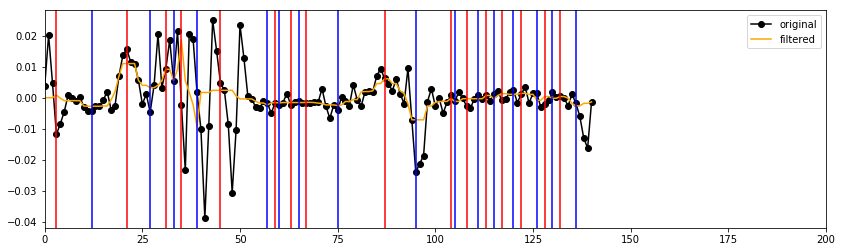

L End reached + -
R End reached - +
Widths: [15, 18, 14, 17, 19, 30, 26, 22, 10, 7, 7, 15, 16, 13, 12, 16, 18, 12, 7, 9, 9, 15, 12, 11, 6, 7, 7, 7, 10, 17, 23, 24, 16, 16]


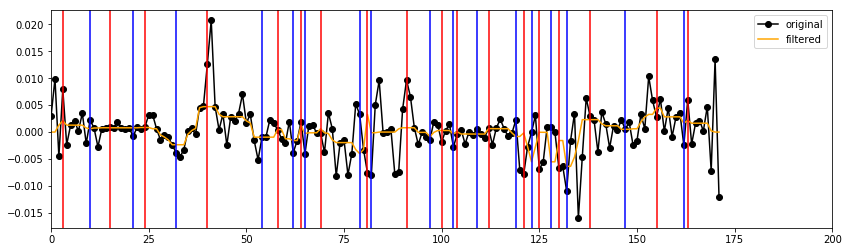

L End reached + -
R End reached - +
Widths: [7, 10, 10, 11, 12, 14, 13, 8, 16, 24, 35, 28, 20, 8, 3, 7, 10, 13, 13, 15, 13, 9, 13, 14]


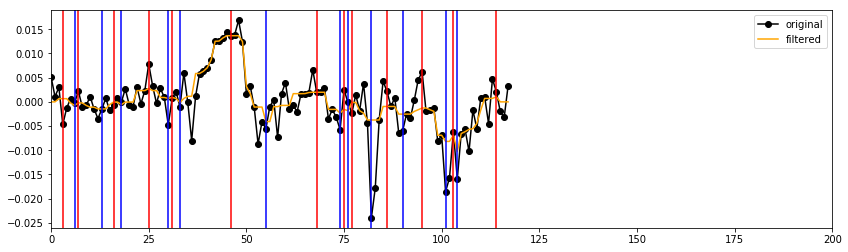

L End reached + -
R End reached - +
Widths: [25, 25, 20, 23, 22, 15, 7, 14, 17, 16, 9, 15, 19, 22, 19, 19]


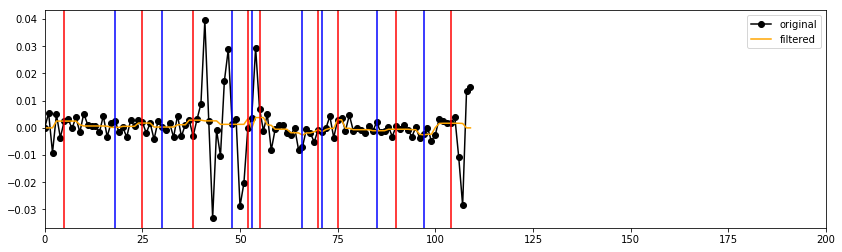

Ends reached 50 times


In [58]:
nod_x_widths,   nod_x_heights, avg_N_w, avg_N_h   = get_peaks_params(head_class='nod',   angle_type=angle_type_prefix+'x')
other_x_widths, other_x_heights, avg_O_w, avg_O_h = get_peaks_params(head_class='other', angle_type=angle_type_prefix+'x')


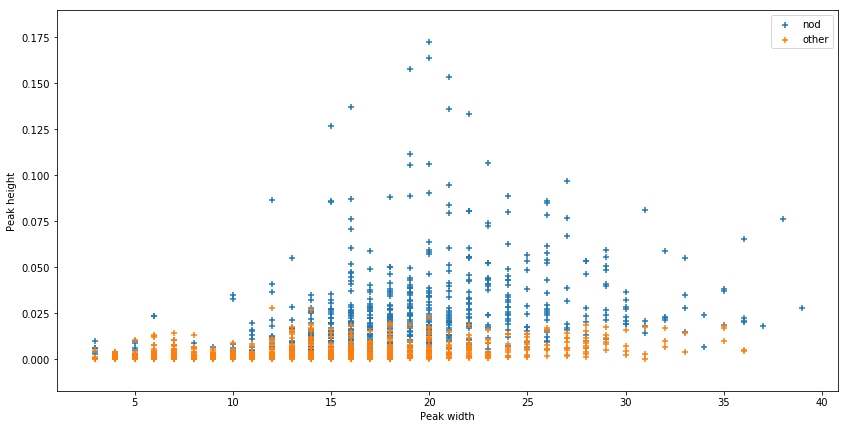

In [59]:
# PER-PEAK
# width and height/width

plt.figure(figsize=(14, 7))
plt.scatter(nod_x_widths, nod_x_heights, label='nod', marker='+')
plt.scatter(other_x_widths, other_x_heights, label='other', marker='+')
plt.xlabel('Peak width')
plt.ylabel('Peak height')
# plt.xlim(0.0, 50)
# plt.ylim(0.0, 0.005)
plt.legend()
plt.show()

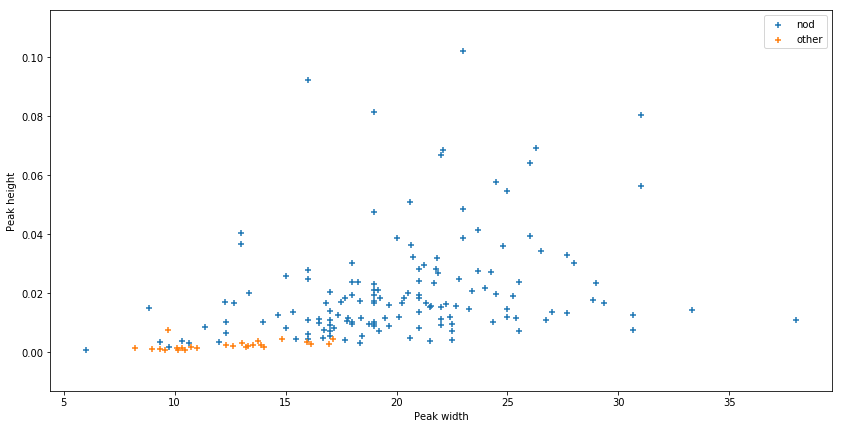

In [27]:
# average width per recording
# average height per recording

plt.figure(figsize=(14, 7))
plt.scatter(avg_N_w, avg_N_h, label='nod', marker='+')
plt.scatter(avg_O_w, avg_O_h, label='other', marker='+')
plt.xlabel('Peak width')
plt.ylabel('Peak height')
# plt.xlim(0.0, 40)
# plt.ylim(0.0, 0.005)
plt.legend()
plt.show()

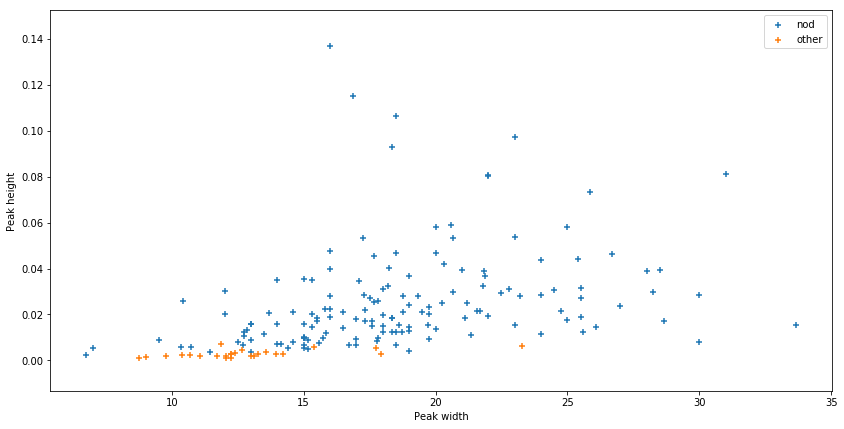

(175, 2) 175
              precision    recall  f1-score   support

       other       0.63      0.48      0.55        25
         nod       0.92      0.95      0.93       150

   micro avg       0.89      0.89      0.89       175
   macro avg       0.77      0.72      0.74       175
weighted avg       0.88      0.89      0.88       175

Accuracy 0.8857142857142857


In [61]:
# average width per recording
# average height per recording

plt.figure(figsize=(14, 7))
plt.scatter(avg_N_w, avg_N_h, label='nod', marker='+')
plt.scatter(avg_O_w, avg_O_h, label='other', marker='+')
plt.xlabel('Peak width')
plt.ylabel('Peak height')
# plt.xlim(0.0, 40)
# plt.ylim(0.0, 0.005)
plt.legend()
plt.show()

from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

random_state = 37

# Stack data
X = np.column_stack((avg_O_w + avg_N_w, avg_O_h + avg_N_h))
y = [0] * len(avg_O_w) + [1] * len(avg_N_w)

# Shuffle data
X, y = shuffle(X, y, random_state=random_state)

print(X.shape, len(y))

# BOUNDARIES
n_neighbors = 5
target_names = ['other', 'nod']

kNN = KNeighborsClassifier(n_neighbors=n_neighbors)
kNN.fit(X, y) 

y_pred = kNN.predict(X)
print(classification_report(y, y_pred, target_names=target_names))
print(f"Accuracy {kNN.score(X, y)}")

In [29]:
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

random_state = 37

# Stack data
X = np.column_stack((avg_O_w + avg_N_w, avg_O_h + avg_N_h))
y = [0] * len(avg_O_w) + [1] * len(avg_N_w)

# Shuffle data
X, y = shuffle(X, y, random_state=random_state)

print(X.shape, len(y))

(171, 2) 171


In [38]:
# BOUNDARIES
n_neighbors = 5
target_names = ['other', 'nod']

kNN = KNeighborsClassifier(n_neighbors=n_neighbors)
kNN.fit(X, y) 

y_pred = kNN.predict(X)
print(classification_report(y, y_pred, target_names=target_names))
print(f"Accuracy {kNN.score(X, y)}")

              precision    recall  f1-score   support

       other       0.64      0.72      0.68        25
         nod       0.95      0.93      0.94       146

   micro avg       0.90      0.90      0.90       171
   macro avg       0.80      0.83      0.81       171
weighted avg       0.91      0.90      0.90       171

Accuracy 0.9005847953216374


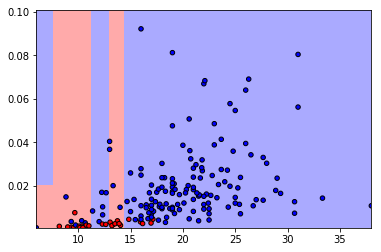

In [39]:
from matplotlib.colors import ListedColormap

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
h = .02  # step size in the mesh

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = kNN.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

In [9]:
x_pred = [5.5, 0.02]
print(kNN.predict([x_pred]), kNN.predict_proba([x_pred]))

[1] [[0.4 0.6]]


In [10]:
print(kNN.score(X, y))

0.9005847953216374


1 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       1.00      1.00      1.00        25
         nod       1.00      1.00      1.00       146

   micro avg       1.00      1.00      1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171

Accuracy 1.0


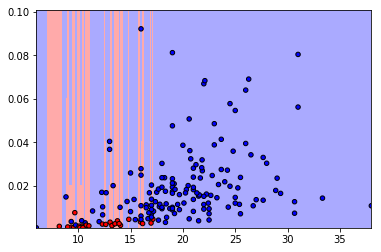

2 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.66      1.00      0.79        25
         nod       1.00      0.91      0.95       146

   micro avg       0.92      0.92      0.92       171
   macro avg       0.83      0.96      0.87       171
weighted avg       0.95      0.92      0.93       171

Accuracy 0.9239766081871345


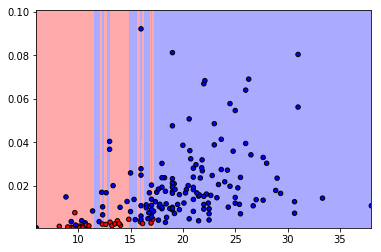

3 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.71      0.68      0.69        25
         nod       0.95      0.95      0.95       146

   micro avg       0.91      0.91      0.91       171
   macro avg       0.83      0.82      0.82       171
weighted avg       0.91      0.91      0.91       171

Accuracy 0.9122807017543859


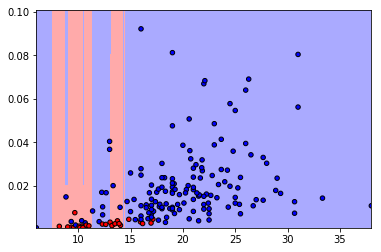

4 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.62      0.72      0.67        25
         nod       0.95      0.92      0.94       146

   micro avg       0.89      0.89      0.89       171
   macro avg       0.79      0.82      0.80       171
weighted avg       0.90      0.89      0.90       171

Accuracy 0.8947368421052632


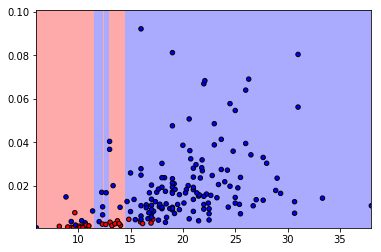

5 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.64      0.72      0.68        25
         nod       0.95      0.93      0.94       146

   micro avg       0.90      0.90      0.90       171
   macro avg       0.80      0.83      0.81       171
weighted avg       0.91      0.90      0.90       171

Accuracy 0.9005847953216374


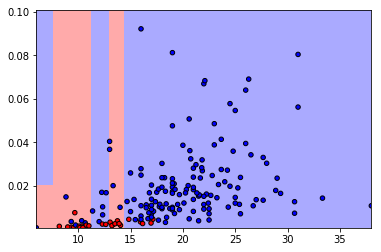

6 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.64      0.72      0.68        25
         nod       0.95      0.93      0.94       146

   micro avg       0.90      0.90      0.90       171
   macro avg       0.80      0.83      0.81       171
weighted avg       0.91      0.90      0.90       171

Accuracy 0.9005847953216374


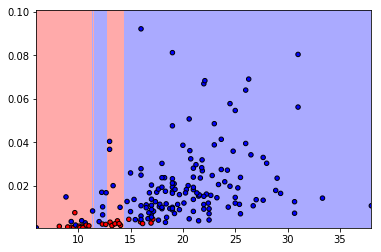

7 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.68      0.68      0.68        25
         nod       0.95      0.95      0.95       146

   micro avg       0.91      0.91      0.91       171
   macro avg       0.81      0.81      0.81       171
weighted avg       0.91      0.91      0.91       171

Accuracy 0.9064327485380117


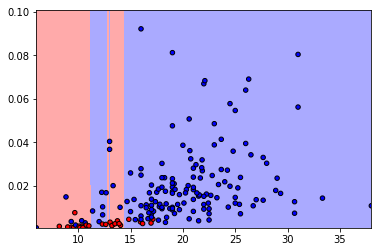

8 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.62      0.72      0.67        25
         nod       0.95      0.92      0.94       146

   micro avg       0.89      0.89      0.89       171
   macro avg       0.79      0.82      0.80       171
weighted avg       0.90      0.89      0.90       171

Accuracy 0.8947368421052632


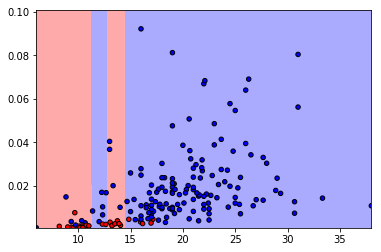

9 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.64      0.72      0.68        25
         nod       0.95      0.93      0.94       146

   micro avg       0.90      0.90      0.90       171
   macro avg       0.80      0.83      0.81       171
weighted avg       0.91      0.90      0.90       171

Accuracy 0.9005847953216374


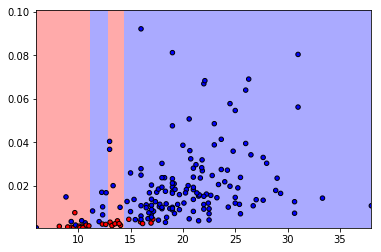

10 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.64      0.72      0.68        25
         nod       0.95      0.93      0.94       146

   micro avg       0.90      0.90      0.90       171
   macro avg       0.80      0.83      0.81       171
weighted avg       0.91      0.90      0.90       171

Accuracy 0.9005847953216374


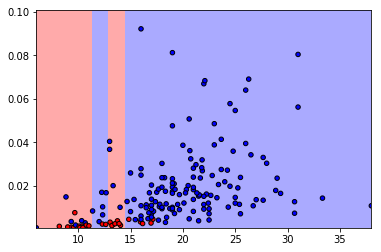

11 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.69      0.72      0.71        25
         nod       0.95      0.95      0.95       146

   micro avg       0.91      0.91      0.91       171
   macro avg       0.82      0.83      0.83       171
weighted avg       0.91      0.91      0.91       171

Accuracy 0.9122807017543859


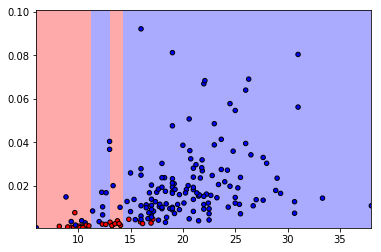

12 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.62      0.72      0.67        25
         nod       0.95      0.92      0.94       146

   micro avg       0.89      0.89      0.89       171
   macro avg       0.79      0.82      0.80       171
weighted avg       0.90      0.89      0.90       171

Accuracy 0.8947368421052632


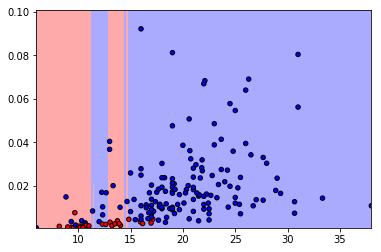

13 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.69      0.72      0.71        25
         nod       0.95      0.95      0.95       146

   micro avg       0.91      0.91      0.91       171
   macro avg       0.82      0.83      0.83       171
weighted avg       0.91      0.91      0.91       171

Accuracy 0.9122807017543859


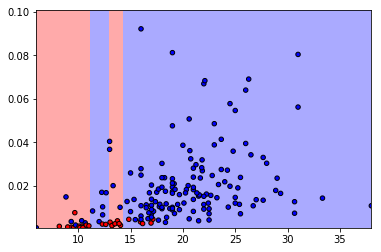

14 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.62      0.72      0.67        25
         nod       0.95      0.92      0.94       146

   micro avg       0.89      0.89      0.89       171
   macro avg       0.79      0.82      0.80       171
weighted avg       0.90      0.89      0.90       171

Accuracy 0.8947368421052632


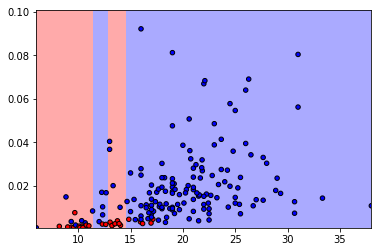

15 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.61      0.68      0.64        25
         nod       0.94      0.92      0.93       146

   micro avg       0.89      0.89      0.89       171
   macro avg       0.78      0.80      0.79       171
weighted avg       0.89      0.89      0.89       171

Accuracy 0.8888888888888888


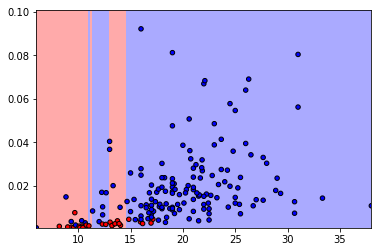

16 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.60      0.72      0.65        25
         nod       0.95      0.92      0.93       146

   micro avg       0.89      0.89      0.89       171
   macro avg       0.78      0.82      0.79       171
weighted avg       0.90      0.89      0.89       171

Accuracy 0.8888888888888888


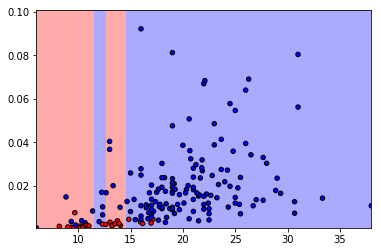

17 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.71      0.68      0.69        25
         nod       0.95      0.95      0.95       146

   micro avg       0.91      0.91      0.91       171
   macro avg       0.83      0.82      0.82       171
weighted avg       0.91      0.91      0.91       171

Accuracy 0.9122807017543859


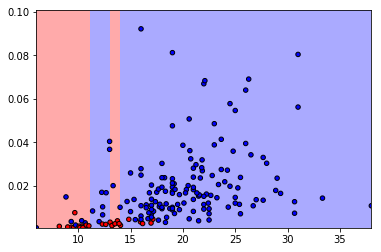

18 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.59      0.76      0.67        25
         nod       0.96      0.91      0.93       146

   micro avg       0.89      0.89      0.89       171
   macro avg       0.78      0.84      0.80       171
weighted avg       0.90      0.89      0.89       171

Accuracy 0.8888888888888888


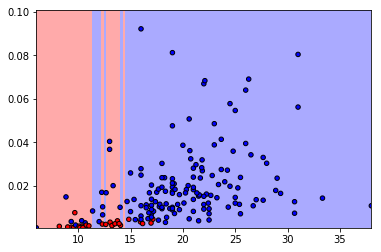

19 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.62      0.52      0.57        25
         nod       0.92      0.95      0.93       146

   micro avg       0.88      0.88      0.88       171
   macro avg       0.77      0.73      0.75       171
weighted avg       0.88      0.88      0.88       171

Accuracy 0.8830409356725146


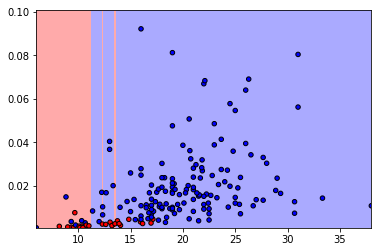

20 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.61      0.68      0.64        25
         nod       0.94      0.92      0.93       146

   micro avg       0.89      0.89      0.89       171
   macro avg       0.78      0.80      0.79       171
weighted avg       0.89      0.89      0.89       171

Accuracy 0.8888888888888888


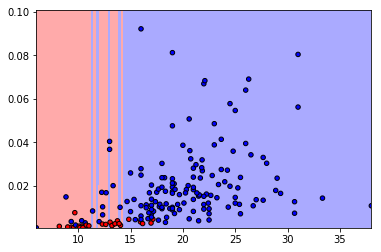

21 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.63      0.48      0.55        25
         nod       0.91      0.95      0.93       146

   micro avg       0.88      0.88      0.88       171
   macro avg       0.77      0.72      0.74       171
weighted avg       0.87      0.88      0.88       171

Accuracy 0.8830409356725146


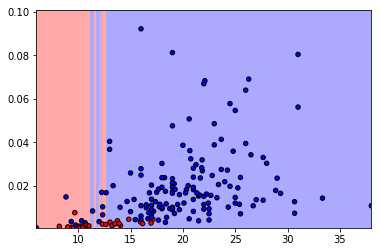

22 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.48      0.52      0.50        25
         nod       0.92      0.90      0.91       146

   micro avg       0.85      0.85      0.85       171
   macro avg       0.70      0.71      0.71       171
weighted avg       0.85      0.85      0.85       171

Accuracy 0.847953216374269


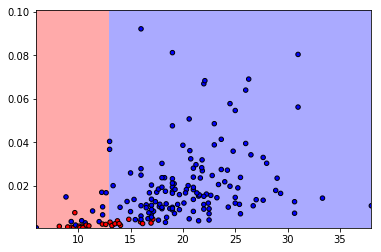

23 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.50      0.44      0.47        25
         nod       0.91      0.92      0.92       146

   micro avg       0.85      0.85      0.85       171
   macro avg       0.70      0.68      0.69       171
weighted avg       0.85      0.85      0.85       171

Accuracy 0.8538011695906432


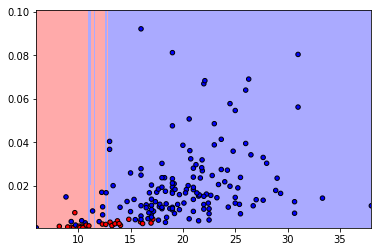

24 neighbors ---------------------------------------------------------
              precision    recall  f1-score   support

       other       0.52      0.52      0.52        25
         nod       0.92      0.92      0.92       146

   micro avg       0.86      0.86      0.86       171
   macro avg       0.72      0.72      0.72       171
weighted avg       0.86      0.86      0.86       171

Accuracy 0.8596491228070176


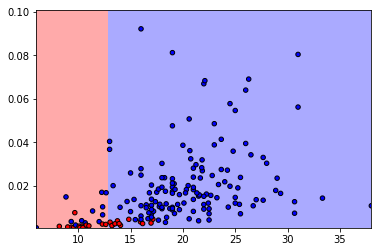

In [45]:
from sklearn.metrics import f1_score

f_macro = []
f_micro = []
f_weighted = []

n_neighbors_range = range(1, 25)

for n_neighbors in n_neighbors_range:
    
    print(f'{n_neighbors} neighbors ---------------------------------------------------------')
    
    kNN = KNeighborsClassifier(n_neighbors=n_neighbors)
    kNN.fit(X, y) 
    
    y_pred = kNN.predict(X)
    print(classification_report(y, y_pred, target_names=target_names))
    print(f"Accuracy {kNN.score(X, y)}")
    f_macro.append(f1_score(y, y_pred, average='macro'))
    f_micro.append(f1_score(y, y_pred, average='micro'))
    f_weighted.append(f1_score(y, y_pred, average='weighted'))
    
    Z = kNN.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

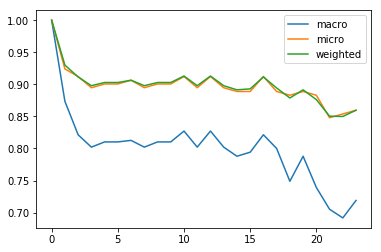

In [48]:
plt.figure()
plt.plot(f_macro, label='macro')
plt.plot(f_micro, label='micro')
plt.plot(f_weighted, label='weighted')
plt.legend()
plt.show()

In [52]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=random_state)
X_resampled, y_resampled = ros.fit_resample(X, y)

print(X_resampled.shape, y_resampled.shape, 146*2)

(292, 2) (292,) 292


              precision    recall  f1-score   support

       other       0.90      0.99      0.94       146
         nod       0.99      0.89      0.94       146

   micro avg       0.94      0.94      0.94       292
   macro avg       0.95      0.94      0.94       292
weighted avg       0.95      0.94      0.94       292

Accuracy 0.9417808219178082


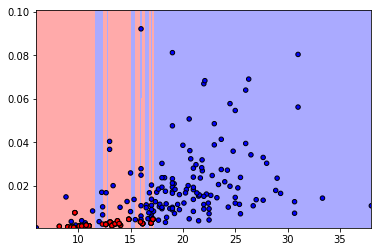

In [54]:
# BOUNDARIES
n_neighbors = 5
target_names = ['other', 'nod']

kNN = KNeighborsClassifier(n_neighbors=n_neighbors)
kNN.fit(X_resampled, y_resampled) 

y_pred = kNN.predict(X_resampled)
print(classification_report(y_resampled, y_pred, target_names=target_names))
print(f"Accuracy {kNN.score(X_resampled, y_resampled)}")

from matplotlib.colors import ListedColormap

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
h = .02  # step size in the mesh

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_resampled[:, 0].min(), X_resampled[:, 0].max()
y_min, y_max = X_resampled[:, 1].min(), X_resampled[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = kNN.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_resampled, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()